# Estruturas para implementação de Filtros IIR

**Disciplina:** ENGG54 - Laboratório Integrado III-A - 2021.2

**Docente:** Paulo Farias

**Discentes:** Ana Clara Batista, André Paiva, Andrey Fontoura, Ariel Lima, Douglas Leite, Guilherme Costa, Jeferson Novaes, João Victor Carneiro, Pedro Augusto Correia, Pedro Freitas

## 1 - Inicialização

### 1.1 - Importação de bibliotecas

In [1732]:
import numpy as np
from scipy import signal, misc, fftpack
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.fft import fft, fftfreq
import warnings
warnings.filterwarnings('ignore')

## 2 - Funções e variáveis usadas na simulação

### 2.1 - Funções Auxiliares

#### 2.1.1 - Funções de plotagem

In [1733]:
figsize = (15, 5)

def plotarSinal(dataset, titulo):
    figure(num=None, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    t = np.linspace(0, len(dataset), len(dataset))
    plt.axhline(y=0, color='black', linestyle='-')
    plt.plot(t, dataset[:])    
    plt.title(titulo)
    plt.xlabel("Amostra")
    plt.ylabel("Amplitude")
    plt.show()

def plotarSinalCompara(data1, data2, titulo):
    figure(num=None, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    t = np.linspace(0, len(data1), len(data1))
    plt.axhline(y=0, color='black', linestyle='-')
    plt.plot(t, data1[:], color='b', label = "Python")
    plt.plot(t, data2[:], color="orange", label = "DSP") 
    plt.title(titulo)
    plt.xlabel("Amostra")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()
    
def plotarFuncaoContinua(data_function, title, N, step):
    figure(num=None, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    x = np.arange(0, N, step)
    y = data_function(x)
    plt.axhline(y=0, color='black', linestyle='-')
    plt.plot(x, y)
    plt.title(title)
    plt.ylabel('Amplitude')
    plt.xlabel('Tempo t(s)')
    plt.show()
    
def plotarAmostras(data, title):
    figure(num=None, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    plt.stem(data, linefmt='b-', basefmt='k-')
    plt.title(title)
    plt.ylabel('Amplitude')
    plt.xlabel('Amostra')
    plt.show()

def plotarAmostrasCompara(data1, data2, title):
    figure(num=None, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    plt.stem(data1, linefmt='b-', basefmt='k-', markerfmt='bo', label="Python")
    plt.stem(data2, linefmt='r-.', basefmt='k-', markerfmt='r.', label="DSP")
    plt.title(title)
    plt.ylabel('Amplitude')
    plt.xlabel('Amostra')
    plt.legend()
    plt.show()
    
def plotarSinalFreq(data, N, T, title):
    yf = fft(data)
    xf = fftfreq(N, T)[:N//2] 
    figure(num=None, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    plt.axhline(y=0, color='black', linestyle='-')
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))    
    plt.title(title)
    plt.ylabel("FFT")
    plt.xlabel("Freq. [Hz]")
    plt.show()

def plotarSinalFreqCompara(data1, data2, N, T, title):
    yf_1 = fft(data1)
    yf_2 = fft(data2)
    xf = fftfreq(N, T)[:N//2] 
    figure(num=None, figsize=figsize, dpi=100, facecolor='w', edgecolor='k')
    plt.axhline(y=0, color='black', linestyle='-')
    plt.plot(xf, 2.0/N * np.abs(yf_1[0:N//2]), 'bo-', label='Python')    
    plt.plot(xf, 2.0/N * np.abs(yf_2[0:N//2]), 'r.--', label="DSP")   
    plt.title(title)
    plt.ylabel("FFT")
    plt.xlabel("Freq. [Hz]")
    plt.legend()
    plt.show()

def plotarFreqz(b, a, titulo):
    w, h = signal.freqz(b, a)
    fig, ax1 = plt.subplots()
    ax1.set_title(titulo)
    ax1.plot(w, 20.0 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequência [rad/s]')
    ax1.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'r')
    ax2.set_ylabel('Fase(rad)', color='r')
    ax2.axis('tight')
    plt.show()

def plotarSOS(sos, titulo):
    w, h = signal.sosfreqz(sos, worN=1500)
    fig, ax1 = plt.subplots()
    ax1.set_title(titulo)
    ax1.plot(w, 20.0 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequência [rad/s]')
    ax1.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'r')
    ax2.set_ylabel('Fase(rad)', color='r')
    ax2.axis('tight')
    plt.show()

#### 2.1.2 - Funções de cálculo

In [1734]:
def float_to_q15(y):
    y_clamped = np.clip(y, -1.0, float.fromhex("0x0.fffe"))
    y_fixed = np.multiply(y_clamped, 32768).astype(np.int16)
    return y_fixed

def q15_to_float(y):
    y_div = np.divide(y, 32768).astype(np.float64)
    return y_div

def array_to_cdata(y):
    out_string = "{\n"
    for i in y:
        out_string += str(i)+",\n"
    out_string = out_string[:-2]
    out_string += "\n}\n"
    return out_string

### 2.2 - Variável de debug

Variável usada para ativar print de coeficientes.

In [1735]:
debugMode = False

## 3 - Datasets usados na simulação

### 3.1 - Soma de senoides

#### 3.1.1 - Parâmetros da soma de senoides

In [1736]:
w_low_continuous = np.pi / 21.74
w_mid_continuous = np.pi / 2.85
w_high_continuous = np.pi / 1.1

ph_low_continuous = np.pi / 7
ph_mid_continuous = 0
ph_high_continuous = np.pi / 3

def sample_low(n):
    return np.sin((w_low_continuous * n) + ph_low_continuous)
    
def sample_mid(n):
    return np.sin((w_mid_continuous * n) + ph_mid_continuous)
                                       
def sample_high(n):
    return np.sin((w_high_continuous * n) + ph_high_continuous)

def sample_input_signal(n):
    return (sample_low(n) + sample_mid(n) + sample_high(n)) / 3.0

if(debugMode):
    print("Sinal de baixa frequência: {0:.5}Hz".format(w_low_continuous / (2*np.pi)))
    print("Sinal de média frequência: {0:.5}Hz".format(w_mid_continuous / (2*np.pi)))
    print("Sinal de alta frequência: {0:.5}Hz".format(w_high_continuous / (2*np.pi)))

#### 3.1.2 - Composição da soma de senoides (sinal contínuo)

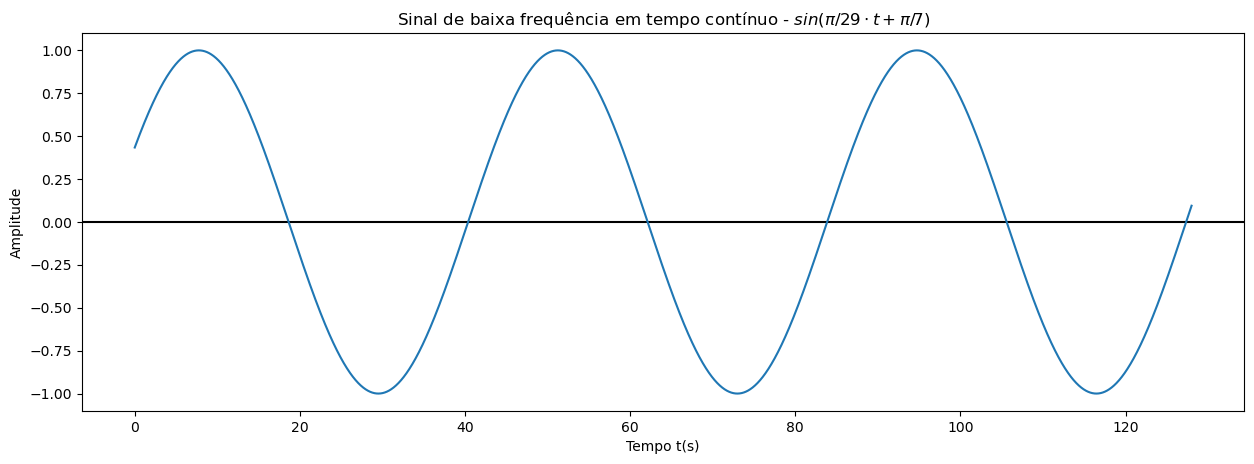

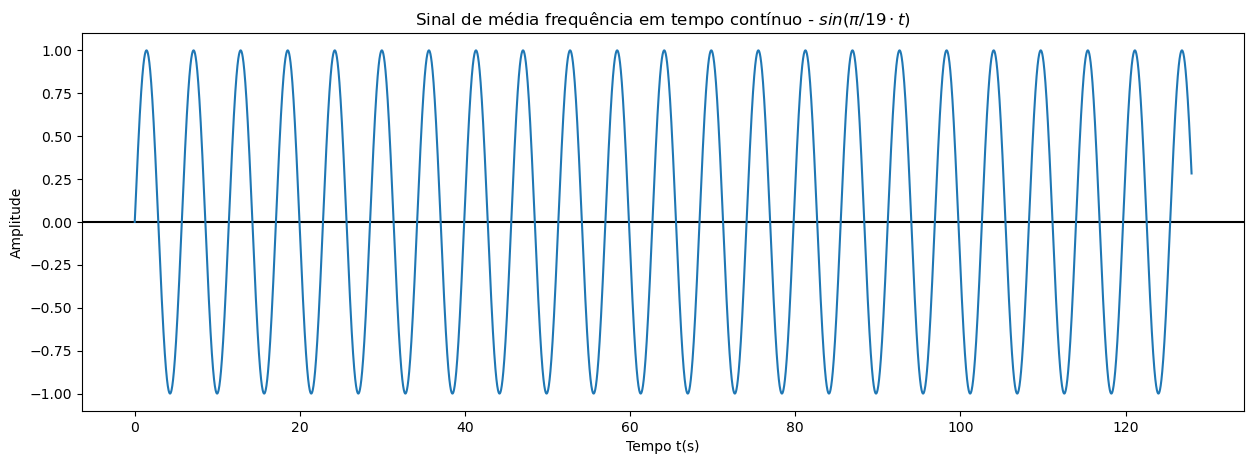

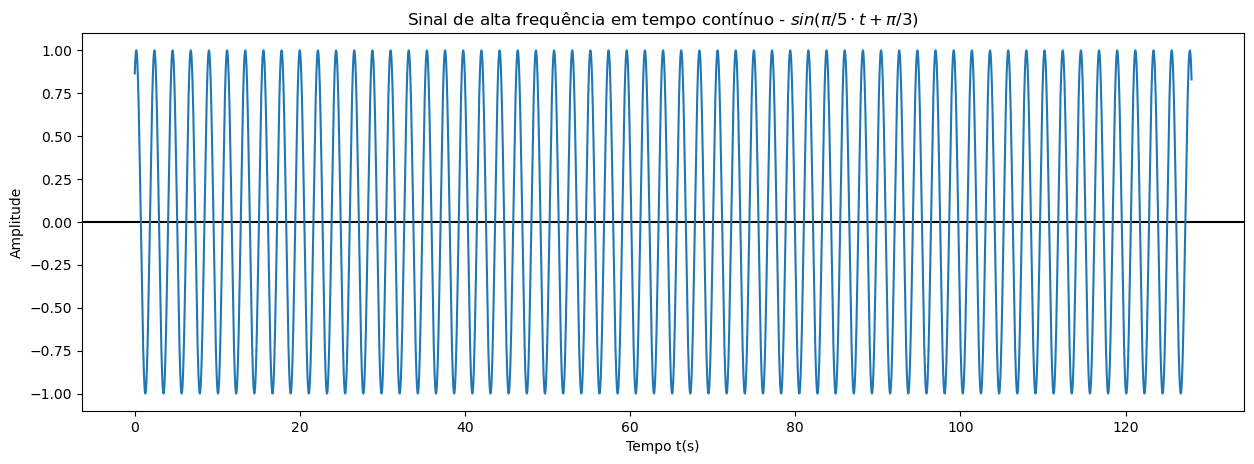

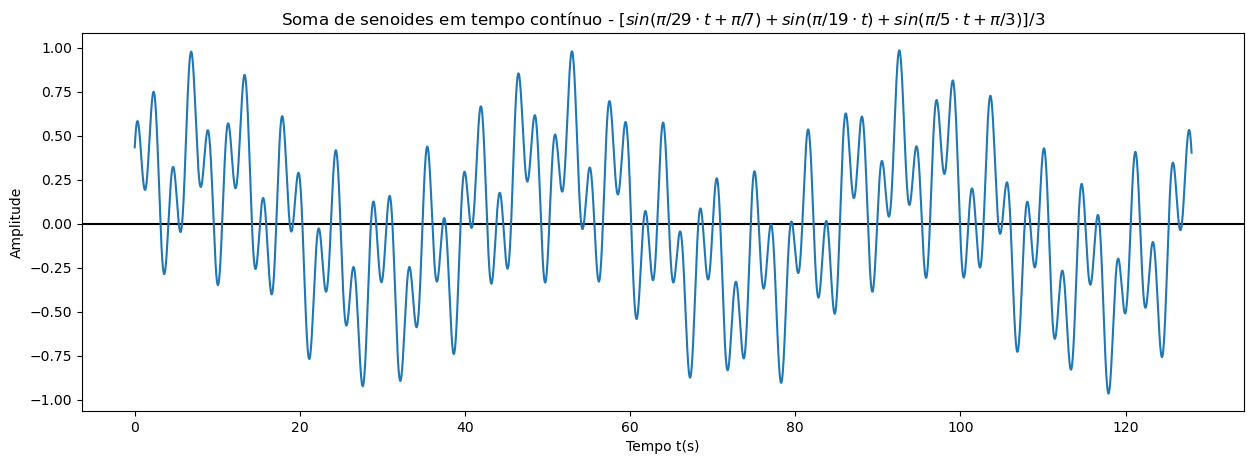

In [1737]:
plotarFuncaoContinua(sample_low, "Sinal de baixa frequência em tempo contínuo - $sin(\pi/29 \cdot t + \pi/7)$", 128, 0.01)
plotarFuncaoContinua(sample_mid, "Sinal de média frequência em tempo contínuo - $sin(\pi/19 \cdot t)$", 128, 0.01)
plotarFuncaoContinua(sample_high, "Sinal de alta frequência em tempo contínuo - $sin(\pi/5 \cdot t + \pi/3)$", 128, 0.01)
plotarFuncaoContinua(sample_input_signal, "Soma de senoides em tempo contínuo - $[sin(\pi/29 \cdot t + \pi/7) + sin(\pi/19 \cdot t) + sin(\pi/5 \cdot t + \pi/3)] / 3$", 128, 0.01)

#### 3.1.3 - Amostragem da soma de senoides

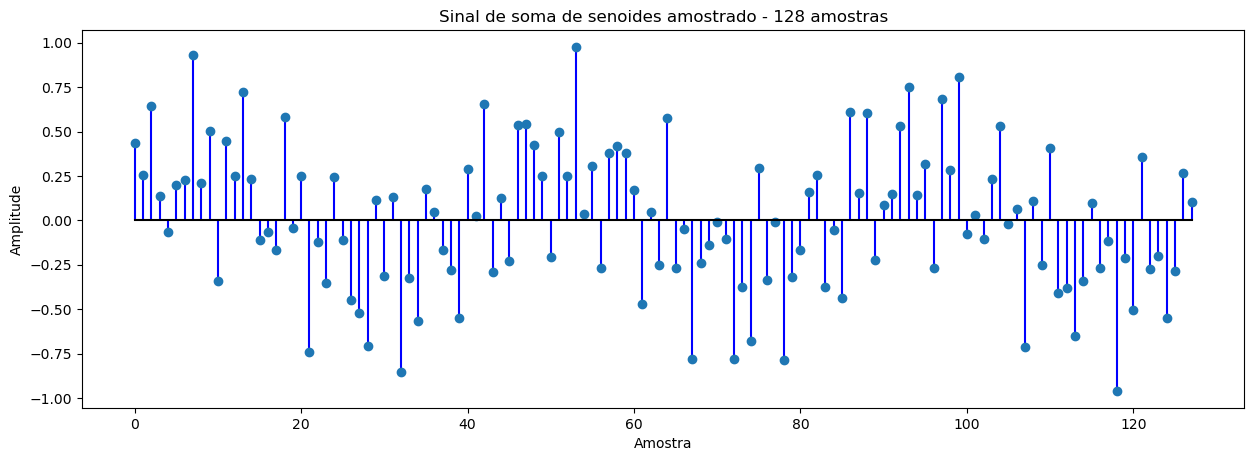

In [1738]:
input_array = np.zeros(128)
for i in range(128):
    input_array[i] = sample_input_signal(i)
plotarAmostras(input_array, "Sinal de soma de senoides amostrado - 128 amostras")

#### 3.1.4 - Plotagem da soma de senoides no domínio da frequência

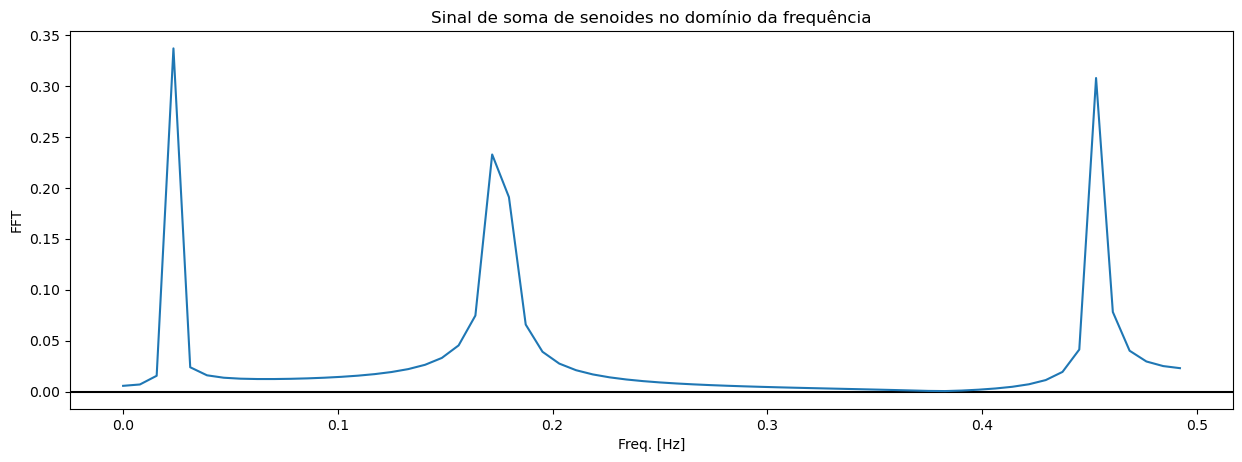

In [1739]:
plotarSinalFreq(input_array, 128, 1, "Sinal de soma de senoides no domínio da frequência")

#### 3.1.5 - Vetor de amostras da soma de senoides e conversão para Q15

In [1740]:
if(debugMode):
    print("Vetor da soma de senoides:", input_array)
    print()
    input_array_Q15 = float_to_q15(input_array)
    print("Vetor da soma de senoides convertido para Q15:", input_array_Q15)
    print()
    # Array no formato CDATA para utilização na placa
    print(array_to_cdata(input_array_Q15))

### 3.2 - Sinal de amostras aleatórias

In [1741]:
random_samples = [-0.1299932293737831, -0.20265844302767877, -0.8148970190249711, 0.993230079552021, 0.5222550196179643, -0.8526176406026489, -0.05299249409229523, 0.15988439811855137, 0.1413592629001481, 0.16294219666512633, -0.42912412197556304, -0.3896302812022303, -0.5188096782611629, -0.589712236263914, 0.8678859026315022, -0.9101625014598123, 0.053441177832854736, 0.4021673429291426, 0.5360216351325628, 0.5144038931493022, 0.5013246197625363, 0.03976760852248429, 0.1221476699198063, 0.8953527198779005, -0.847610521371752, -0.41274902740763886, -0.19627704694610193, 0.5204114181876809, -0.8751776919821124, 0.4354108776359311, 0.03426417650100744, -0.1964877185830698, -0.9608224520439139, 0.9846691369616143, 0.7090494796190812, -0.05743935399211697, 0.9133336930583273, -0.06580071517530439, 0.14641067172689826, -0.5582879607761413, -0.12938440222692305, -0.6853655535280134, 0.5459200963799704, -0.7733736467070587, 0.2859333796588177, 0.04081224676948758, -0.36178654332671956, 0.050398167183346, -0.8458886328752966, 0.8512798982997059, 0.02537066551137568, -0.682238016561268, 0.8756833032605313, -0.6567661575276948, 0.3745662381140886, 0.4784416087064238, 0.8266169739287887, 0.8177832890142793, -0.719981126265566, -0.8052373235535613, 0.9461165032146812, -0.1819549678146224, -0.311200920689932, 0.815816412461273, 0.12867968415281594, 0.6262294592527975, 0.5185815470723283, 0.30573847567335566, -0.42340236414982324, -0.8674005347133762, 0.22373608236105524, -0.8390675657785394, 0.22740368695466118, 0.18604159297244593, -0.7580387911804656, 0.49779620710275574, 0.6513429590257223, -0.7325005658987995, 0.8038762823076286, -0.9210571783943629, 0.45766744679744464, 0.591139758397409, 0.6734493392709984, -0.9811259759712676, -0.5439170936094473, 0.8466358634880711, -0.9200338915119184, -0.7726940652291681, -0.5693830888045088, -0.83631972081694, 0.6522356021896085, -0.6951991406797409, -0.4306324238378454, -0.8189240951561292, -0.23659404720643362, -0.10364821006376723, 0.498956166371173, -0.1276420155108926, -0.8493395619933364, -0.19192837304347643, 0.004081670303439644, 0.7341728258152065, 0.7314280389791128, 0.16808587514340445, -0.3467120711576088, 0.10735479615653665, -0.40146647446322015, 0.4730344245404279, -0.4703229830163185, 0.3990788591422929, 0.8949665211117515, 0.9809468003704334, -0.16310912658774912, 0.11599121833974357, -0.7198080980755956, -0.4607635392474325, -0.965777833765511, -0.953324143850848, 0.018872999754086184, 0.5527483894328551, 0.510921390673263, 0.49991639268595445, -0.8918238236240132, 0.6475972563686763, 0.37335537287444387, 0.9708334320913996, -0.800268205754086, 0.5845842775864385]

#### 3.2.1 - Plotagem da forma de onda do sinal aleatório

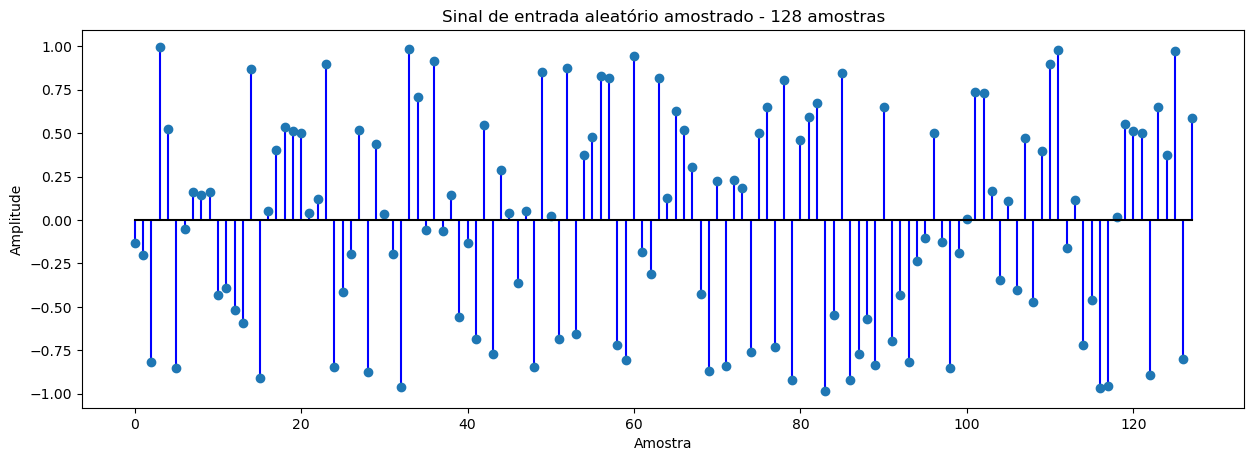

In [1742]:
plotarAmostras(random_samples, "Sinal de entrada aleatório amostrado - 128 amostras")

#### 3.2.2 - Plotagem do sinal aleatório no domínio da frequência

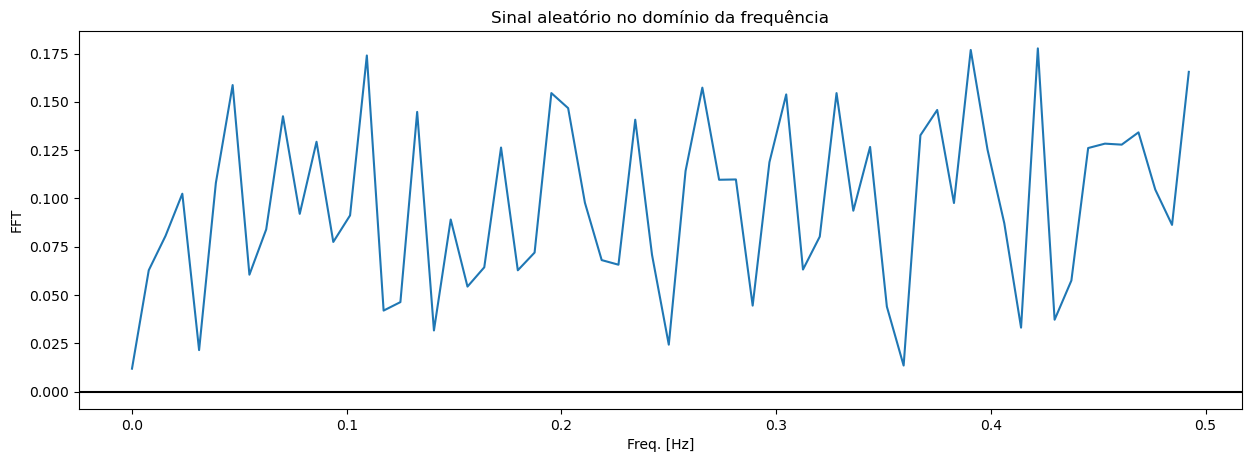

In [1743]:
plotarSinalFreq(random_samples, 128, 1, "Sinal aleatório no domínio da frequência")

#### 3.2.3 Vetor de amostras do sinal aleatório e conversão para Q15

In [1744]:
if(debugMode):
    print("Vetor do sinal aleatório:", random_samples)
    print()
    random_samples_Q15 = float_to_q15(random_samples)
    print("Vetor do sinal aleatório convertido para Q15:", random_samples_Q15)
    print()
    # Array no formato CDATA para utilização na placa
    print(array_to_cdata(random_samples_Q15))

## 4 - Filtros e Comparação de Resultados

### 4.1 - Cálculo dos coeficientes de um filtro passa-baixa butterworth

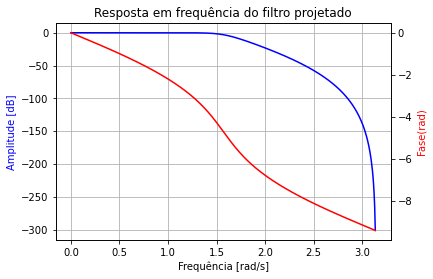

In [1745]:
N = 6
Wn = 0.25
num, den = signal.butter(N, Wn, btype='low', analog=False, output='ba', fs=1)
sos = signal.butter(N, Wn, btype='low', analog=False, output='sos', fs=1)

if(debugMode):
    print("Coeficientes do numerador (b's):")
    print(num)
    print()
    print("Coeficientes do denominador (a's):")
    print(den)
    print()
    print("Coeficientes da forma em cascata:")
    print(sos)

plotarFreqz(num, den, "Resposta em frequência do filtro projetado")

### 4.2 - Conversão dos coeficientes do numerador e denominador do filtro para Q15

In [1746]:
if(debugMode):
    print("Vetor dos numeradores (b's):", num)
    print()
    num_Q15 = float_to_q15(num)
    print("Vetor dos numeradores convertido para Q15:", num_Q15)
    print()
    # Array no formato CDATA para utilização na placa
    print(array_to_cdata(num_Q15))

In [1747]:
if(debugMode):
    print("Vetor dos denominadores (a's):", den)
    print()
    den_Q15 = float_to_q15(den)
    print("Vetor dos denominadores convertido para Q15:", den_Q15)
    print()
    # Array no formato CDATA para utilização na placa
    print(array_to_cdata(den_Q15))

### 4.3 - Implementação do filtro em Forma Direta I

#### 4.3.1 - Função da Forma Direta I

In [1748]:
def butterworthIIRTypeI(x, b, a):
    def x_at(n):
        if n < 0:
            return 0
        else:
            return x[n]

    def y_at(n):
        if n < 0:
            return 0
        else:
            return y[n]

    y = np.zeros(128)

    for n in range(128):
        for i in range(N+1):
            y[n] += b[i]* x_at(n - i) 
        for j in range(1, N+1):
            y[n] -= a[j]*y_at(n - j) 
    return y

#### 4.3.2 - Soma de senos

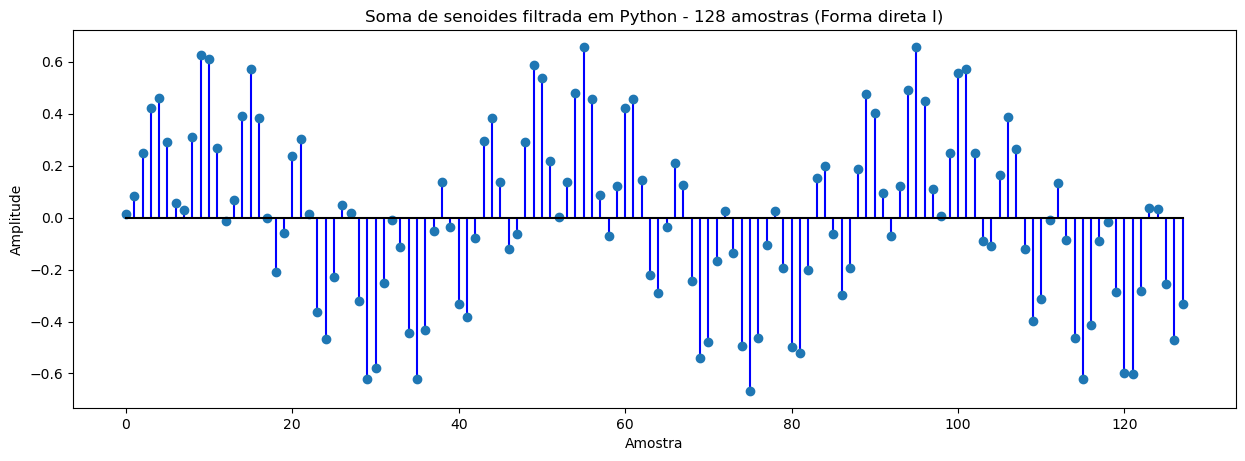

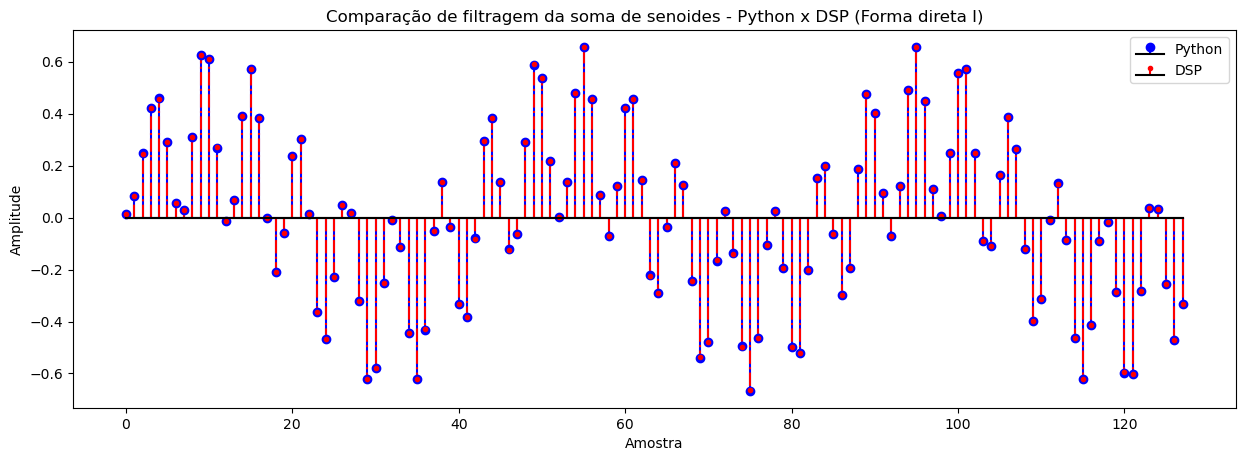

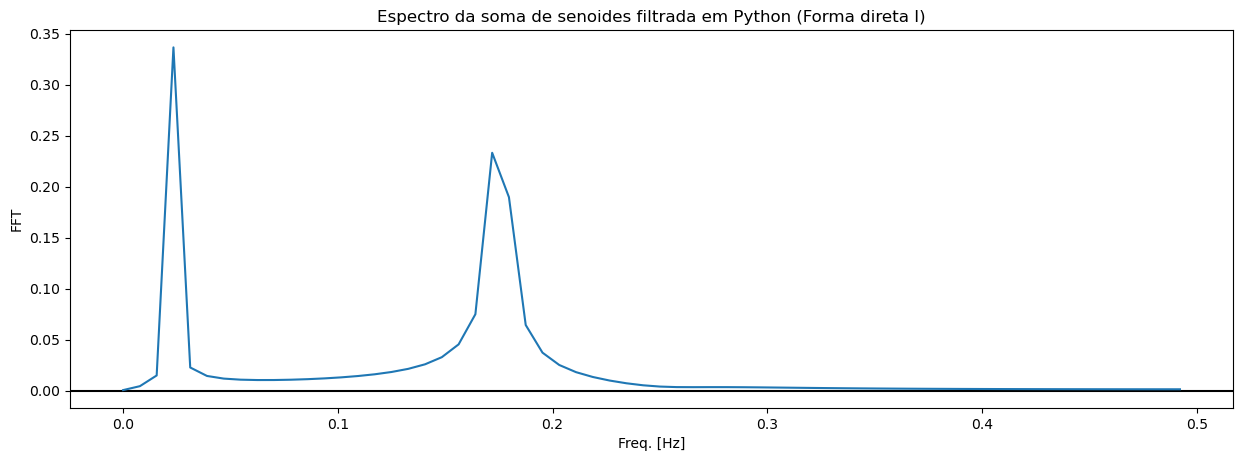

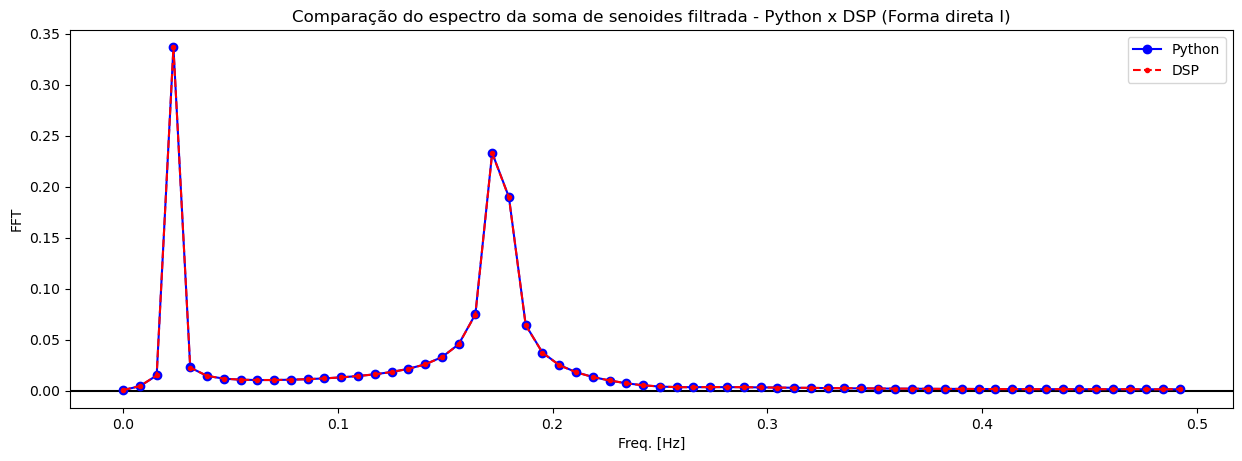

In [1749]:
y_sin = butterworthIIRTypeI(input_array, num, den)

dsp_sin = np.array([416,2752,8064,13856,15008,9472,1856,928,10112,20448,19936,8832,-384,2240,12832,18752,12576,-64,-6848,-1952,7744,9920,480,-11968,-15296,-7456,1536,544,-10464,-20352,-18912,-8256,-256,-3744,-14528,-20352,-14112,-1664,4448,-1216,-10912,-12512,-2656,9696,12512,4448,-4032,-2112,9472,19328,17600,7136,32,4448,15744,21440,14976,2848,-2368,4000,13824,14976,4736,-7328,-9536,-1184,6816,4096,-7968,-17632,-15712,-5408,864,-4544,-16288,-21792,-15168,-3488,768,-6400,-16288,-17056,-6592,4992,6528,-2112,-9728,-6304,6080,15520,13184,3136,-2304,3936,16032,21440,14720,3552,224,8192,18240,18688,8160,-2912,-3616,5376,12672,8672,-3968,-13056,-10272,-352,4288,-2816,-15200,-20352,-13536,-2912,-608,-9344,-19520,-19744,-9216,1216,1056,-8384,-15424,-10912])
sin_converted = q15_to_float(dsp_sin)

plotarAmostras(y_sin, "Soma de senoides filtrada em Python - 128 amostras (Forma direta I)")
plotarAmostrasCompara(y_sin, sin_converted, "Comparação de filtragem da soma de senoides - Python x DSP (Forma direta I)")
plotarSinalFreq(y_sin, 128, 1, "Espectro da soma de senoides filtrada em Python (Forma direta I)")
plotarSinalFreqCompara(y_sin, sin_converted, 128, 1, "Comparação do espectro da soma de senoides filtrada - Python x DSP (Forma direta I)")

if(debugMode):
    print("Resultado em float (Python):", y_sin)
    print()
    print("Resultado em Q15 (Python):", float_to_q15(y_sin))
    print()
    print("Resultado em float (DSP):")
    print(sin_converted)
    print()
    print("Resultado em Q15 (DSP):")
    print(dsp_sin)

#### 4.3.3 - Sinal aleatório

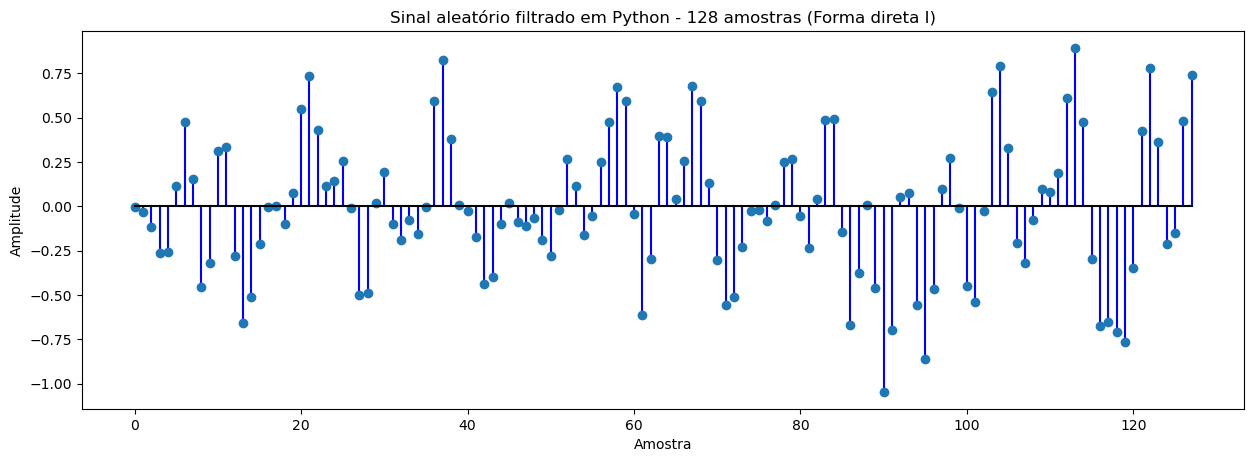

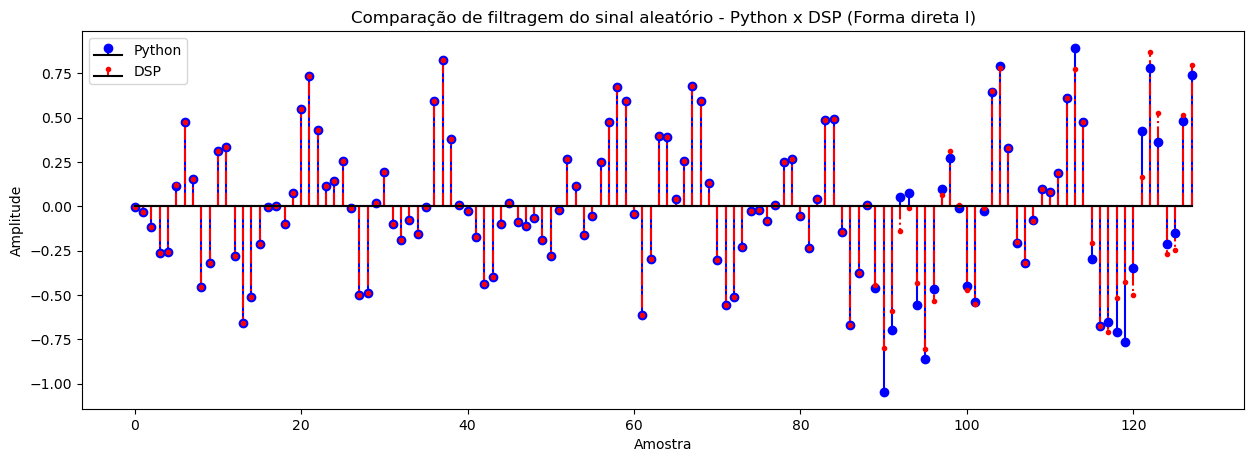

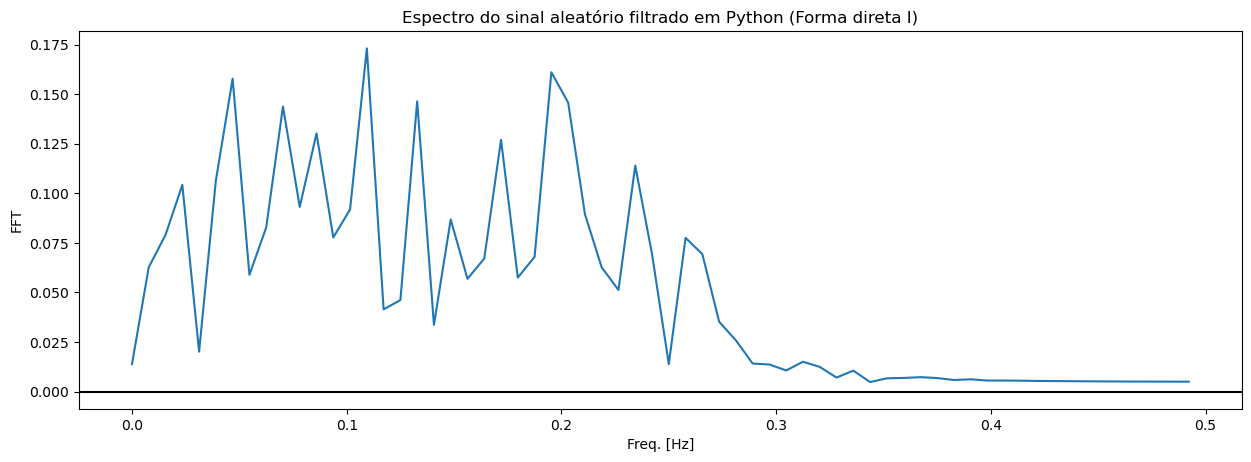

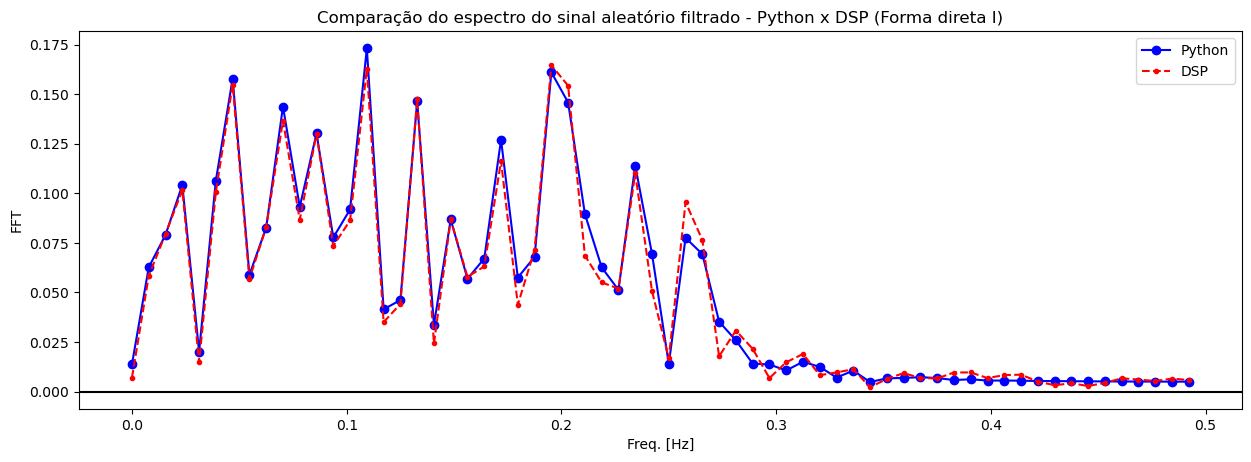

In [1750]:
y_random = butterworthIIRTypeI(random_samples, num, den)

dsp_random = np.array([-126,-952,-3761,-8505,-8447,3875,15685,5041,-14878,-10469,10258,10987,-9221,-21585,-16819,-6925,-167,152,-3258,2453,17977,24194,14192,3770,4652,8352,-335,-16273,-15974,724,6306,-3322,-6103,-2555,-5131,-112,19548,27088,12432,258,-774,-5691,-14385,-13030,-3305,563,-2910,-3595,-2144,-6116,-9090,-701,8715,3785,-5184,-1731,8141,15617,22079,19500,-1305,-20124,-9648,12969,12807,1440,8311,22226,19456,4372,-9851,-18208,-16678,-7520,-755,-634,-2738,220,8164,8685,-1829,-7732,1444,16029,16170,-4784,-21961,-12211,254,-14557,-26088,-19225,-4561,-351,-14141,-26367,-17550,2174,10331,335,-15520,-18042,-372,21307,25677,10717,-6535,-10365,-2665,3253,2744,6125,20005,25373,15641,-6686,-22088,-23220,-16895,-13878,-16289,5389,28620,17274,-8853,-8008,16937,26229])
random_converted = q15_to_float(dsp_random)

plotarAmostras(y_random, "Sinal aleatório filtrado em Python - 128 amostras (Forma direta I)")
plotarAmostrasCompara(y_random, random_converted, "Comparação de filtragem do sinal aleatório - Python x DSP (Forma direta I)")
plotarSinalFreq(y_random, 128, 1, "Espectro do sinal aleatório filtrado em Python (Forma direta I)")
plotarSinalFreqCompara(y_random, random_converted, 128, 1, "Comparação do espectro do sinal aleatório filtrado - Python x DSP (Forma direta I)")

if(debugMode):
    print("Resultado em float (Python):", y_random)
    print()
    print("Resultado em Q15 (Python):", float_to_q15(y_random))
    print()
    print("Resultado em float (DSP):")
    print(random_converted)
    print()
    print("Resultado em Q15 (DSP):")
    print(dsp_random)

### 4.4 - Implementação do filtro em Forma Direta II

#### 4.4.1 - Função da Forma Direta II

In [1751]:
def butterworthIIRTypeII(x, b, a):
    def x_at(n):
        if n < 0:
            return 0
        else:
            return x[n]
    
    def v_at(n):
        if n < 0:
            return 0
        else:
            return v[n]    
        
    v = np.zeros(128)
    y = np.zeros(128)
    
    for n in range(128):
        v[n] = x_at(n) 
        for i in range(1, N+1):
            v[n] += -a[i]*v_at(n - i) 
        for j in range(N+1):
            y[n] += b[j]*v_at(n - j)     
    return y

#### 4.4.2 - Soma de senos

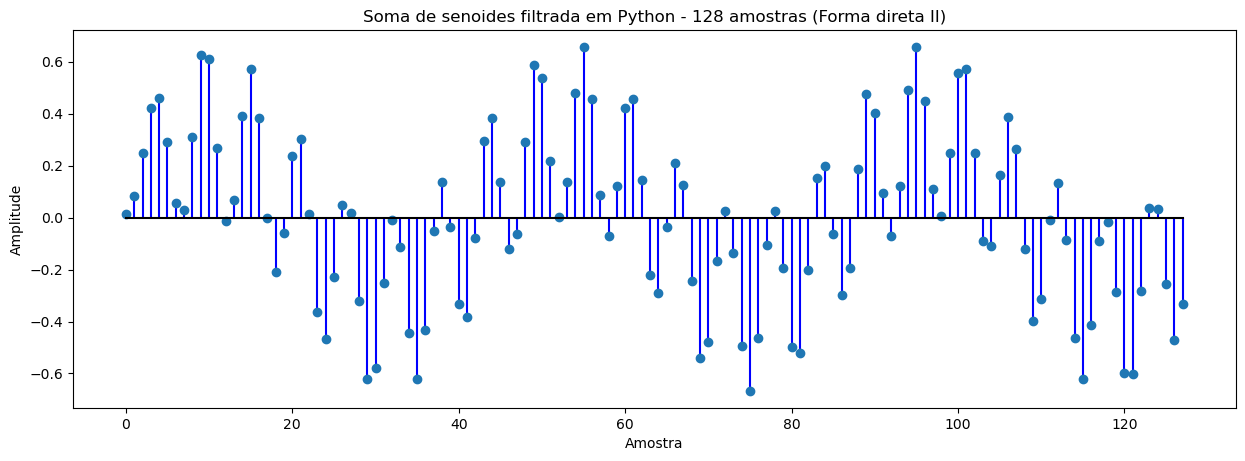

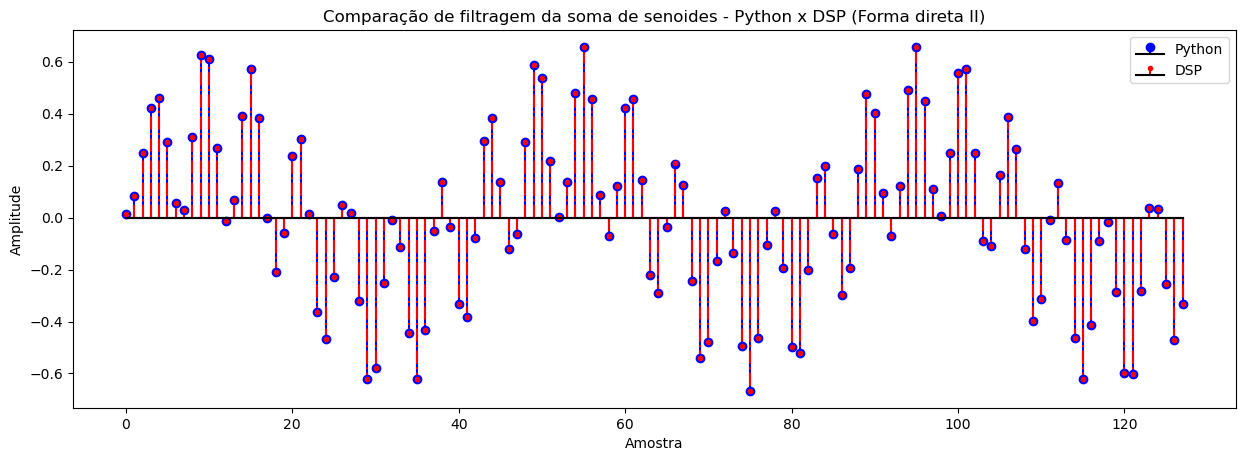

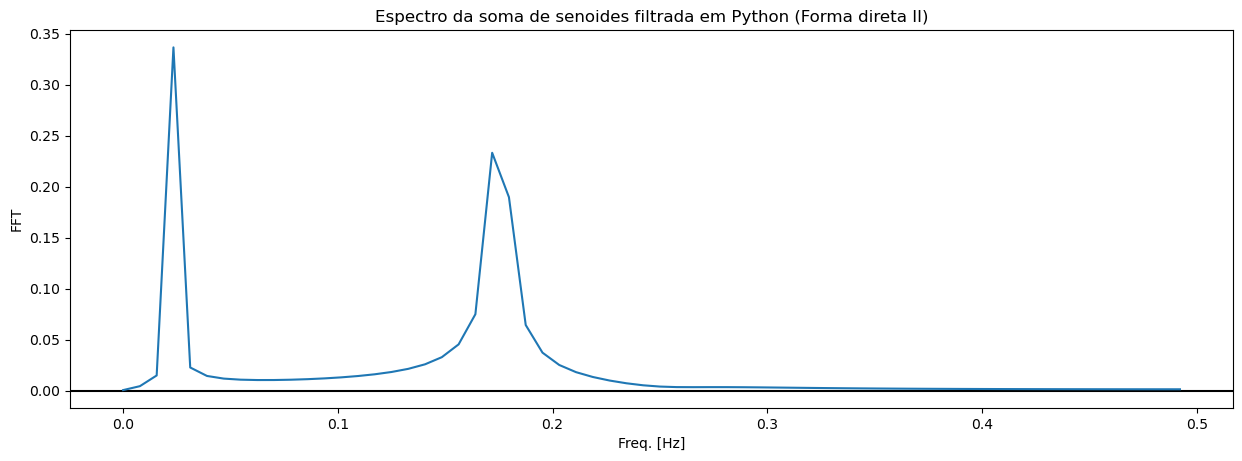

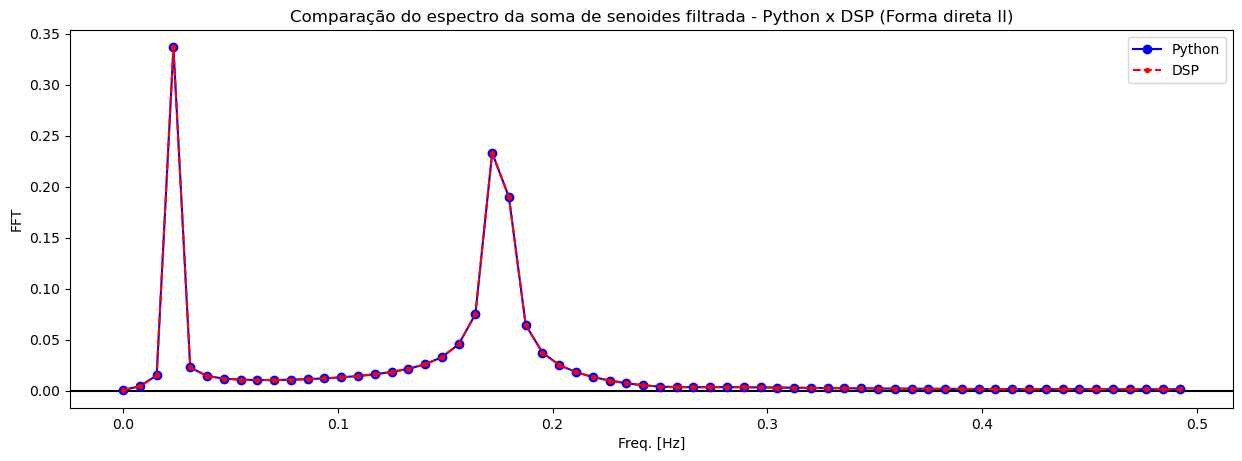

In [1752]:
y_sin = butterworthIIRTypeII(input_array, num, den)

dsp_sin = np.array([420,2766,8076,13830,15029,9501,1810,901,10106,20459,19978,8824,-418,2202,12830,18764,12604,-68,-6873,-1933,7779,9962,486,-11954,-15321,-7456,1565,561,-10474,-20343,-18929,-8252,-252,-3689,-14535,-20398,-14116,-1645,4471,-1176,-10944,-12559,-2613,9674,12515,4469,-4028,-2134,9468,19294,17627,7157,10,4434,15742,21455,14979,2866,-2384,3997,13832,14989,4718,-7293,-9526,-1223,6815,4111,-7960,-17649,-15684,-5420,875,-4512,-16250,-21814,-15200,-3524,791,-6372,-16314,-17089,-6619,4989,6514,-2116,-9762,-6346,6075,15521,13199,3114,-2351,3949,16064,21452,14727,3545,214,8182,18262,18721,8161,-2928,-3647,5373,12701,8676,-3965,-13055,-10298,-353,4333,-2808,-15220,-20392,-13556,-2903,-579,-9352,-19577,-19768,-9208,1253,1089,-8382,-15459,-10930])
sin_converted = q15_to_float(dsp_sin)

plotarAmostras(y_sin, "Soma de senoides filtrada em Python - 128 amostras (Forma direta II)")
plotarAmostrasCompara(y_sin, sin_converted, "Comparação de filtragem da soma de senoides - Python x DSP (Forma direta II)")
plotarSinalFreq(y_sin, 128, 1, "Espectro da soma de senoides filtrada em Python (Forma direta II)")
plotarSinalFreqCompara(y_sin, sin_converted, 128, 1, "Comparação do espectro da soma de senoides filtrada - Python x DSP (Forma direta II)")

if(debugMode):
    print("Resultado em float (Python):", y_sin)
    print()
    print("Resultado em Q15 (Python):", float_to_q15(y_sin))
    print()
    print("Resultado em float (DSP):")
    print(sin_converted)
    print()
    print("Resultado em Q15 (DSP):")
    print(dsp_sin)

#### 4.4.3 - Sinal aleatório

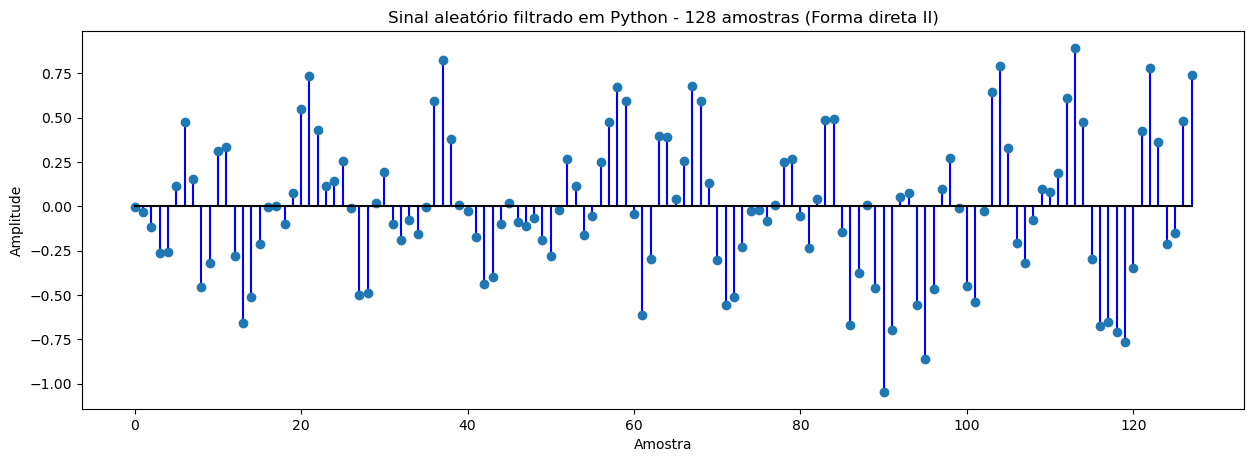

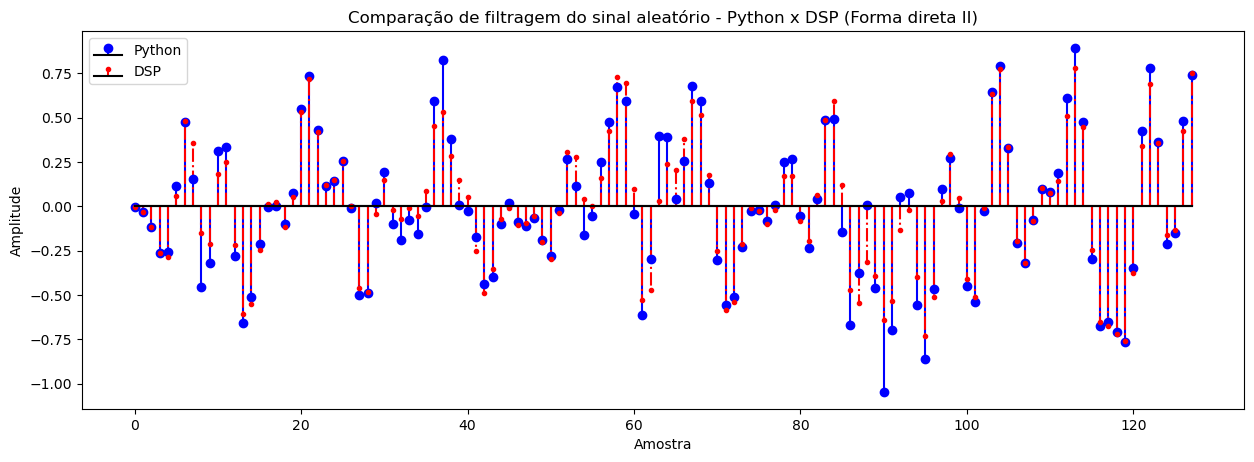

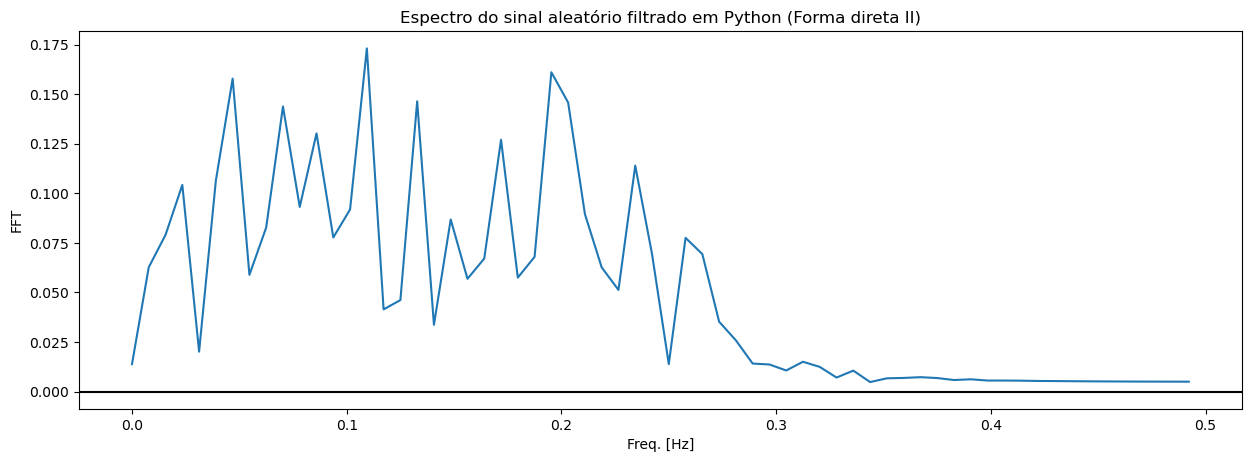

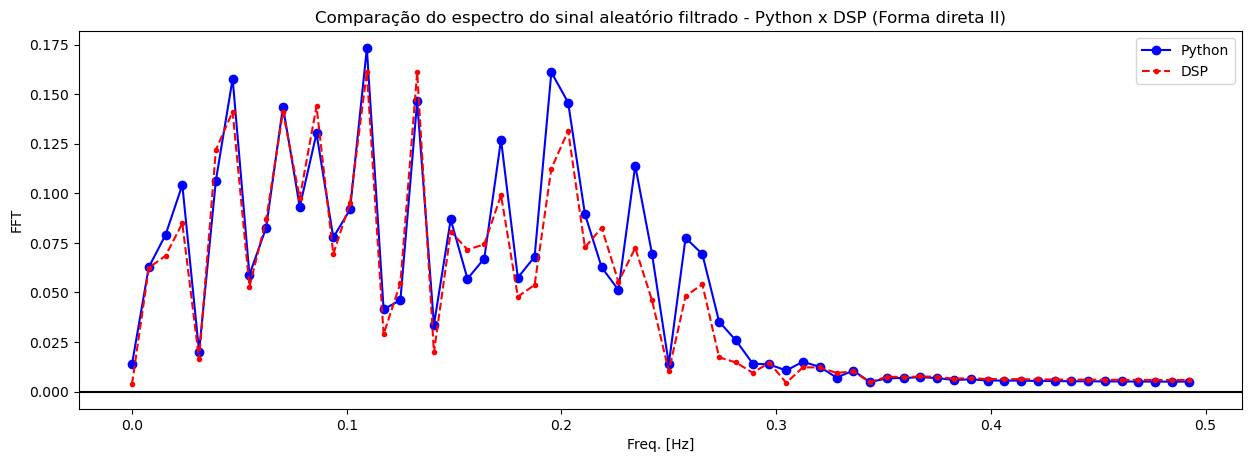

In [1753]:
y_random = butterworthIIRTypeII(random_samples, num, den)

dsp_random = np.array([-126,-952,-3761,-8650,-9414,1869,15838,11802,-4885,-7014,6049,8142,-7090,-19780,-18013,-8008,525,794,-3717,1756,17458,23601,13850,3992,4926,8351,97,-15078,-15800,-1452,4895,-731,-2341,-350,-1807,2840,14899,17380,9371,4956,1734,-8241,-15978,-11569,-2348,-292,-3476,-3092,-1809,-6485,-9723,-1157,10130,9119,1383,125,5282,13968,23913,22895,3241,-17248,-15374,942,7783,6715,12376,19574,16893,5853,-8315,-19064,-17587,-7017,-220,-929,-3241,-736,5674,5699,-2658,-6429,2184,15990,19483,3995,-15498,-17885,-10321,-12840,-21041,-17522,-4413,-681,-13009,-23904,-16651,1014,9738,1644,-13443,-16637,-202,20755,25424,10984,-6361,-10513,-2773,3336,2574,4668,16632,25628,14765,-8127,-21256,-22127,-23644,-24807,-12200,11104,22709,11711,-5187,-4388,13853,24721])
random_converted = q15_to_float(dsp_random)

plotarAmostras(y_random, "Sinal aleatório filtrado em Python - 128 amostras (Forma direta II)")
plotarAmostrasCompara(y_random, random_converted, "Comparação de filtragem do sinal aleatório - Python x DSP (Forma direta II)")
plotarSinalFreq(y_random, 128, 1, "Espectro do sinal aleatório filtrado em Python (Forma direta II)")
plotarSinalFreqCompara(y_random, random_converted, 128, 1, "Comparação do espectro do sinal aleatório filtrado - Python x DSP (Forma direta II)")

if(debugMode):
    print("Resultado em float (Python):", y_random)
    print()
    print("Resultado em Q15 (Python):", float_to_q15(y_random))
    print()
    print("Resultado em float (DSP):")
    print(random_converted)
    print()
    print("Resultado em Q15 (DSP):")
    print(dsp_random)

In [1754]:
if(debugMode):
    # secoes de segunda ordem já divididas por 2 no numerador
    sos = [[ 0.0295882236, 0.0591764473, 0.0295882236, 1.00000000, -0.000000000000000111022302, 0.0173323801],
    [ 0.5 , 1 , 0.5 , 1, -0.000000000000000111022302, 0.171572875],
    [ 0.5, 1,  0.5, 1, -0.000000000000000222044605, 0.588790706]]

    print(sos)
    print(float_to_q15(sos))

    y = signal.sosfilt(sos, input_array)

    print(float_to_q15(y))

### 4.5 - Implementação do filtro em Forma Direta I Transposta

#### 4.5.1 - Função da Forma Direta I Transposta

In [1755]:
def butterworthIIRTypeITransposed(x, b, a):
    def x_at(n):
        if n < 0:
            return 0
        else:
            return x[n]

    def y_at(n):
        if n < 0:
            return 0
        else:
            return y[n]

    y = np.zeros(128)

    for n in range(128):
        for j in range(1, N+1):
            y[n] -= a[j]*y_at(n - j) 
        for i in range(N+1):
            y[n] += b[i]* x_at(n - i) 
    return y


#### 4.5.2 - Soma de senos

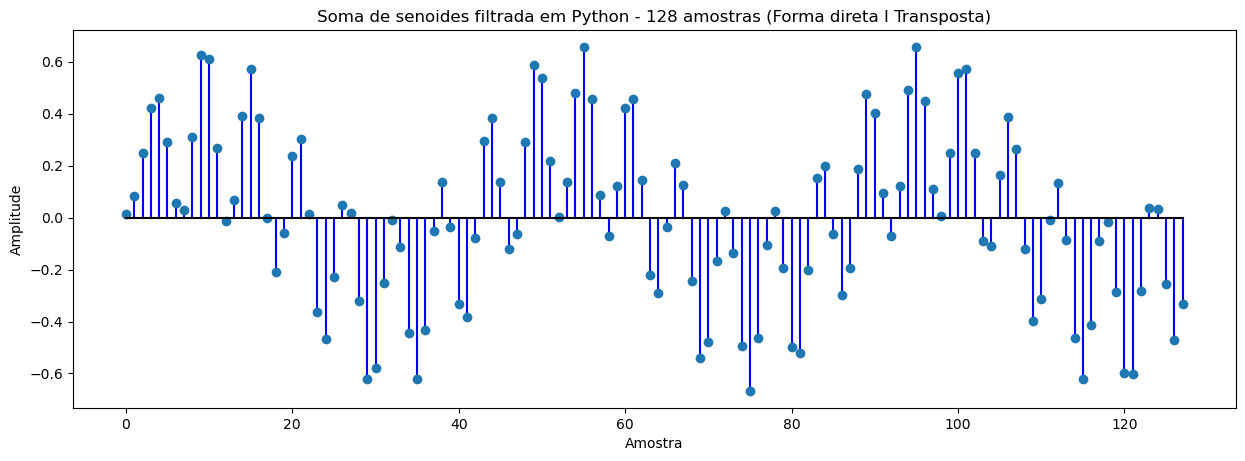

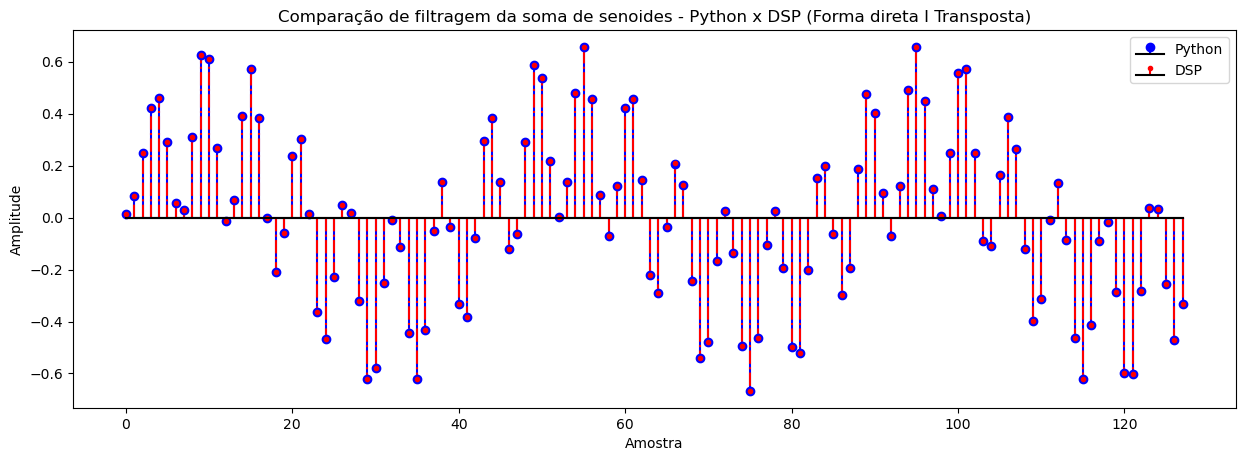

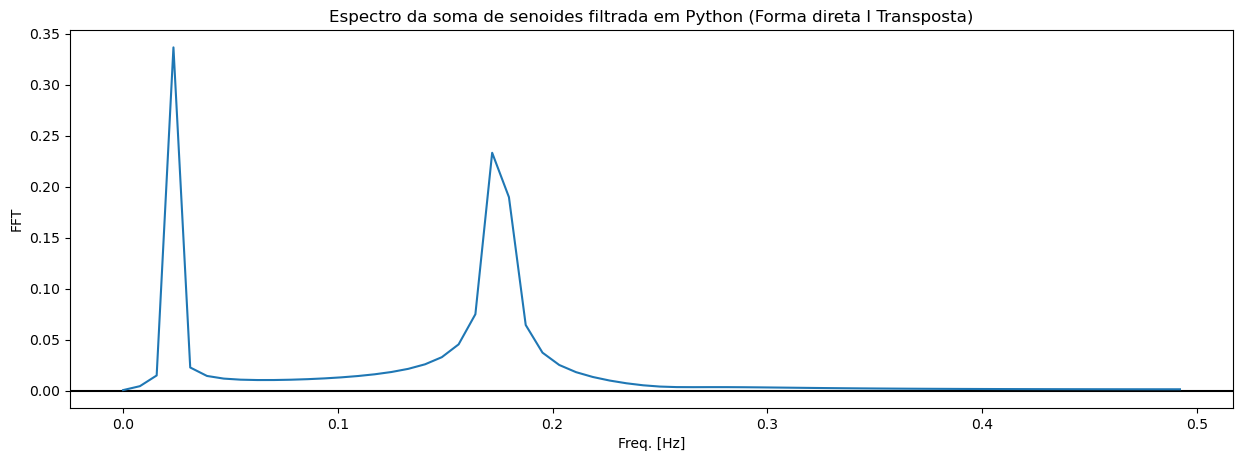

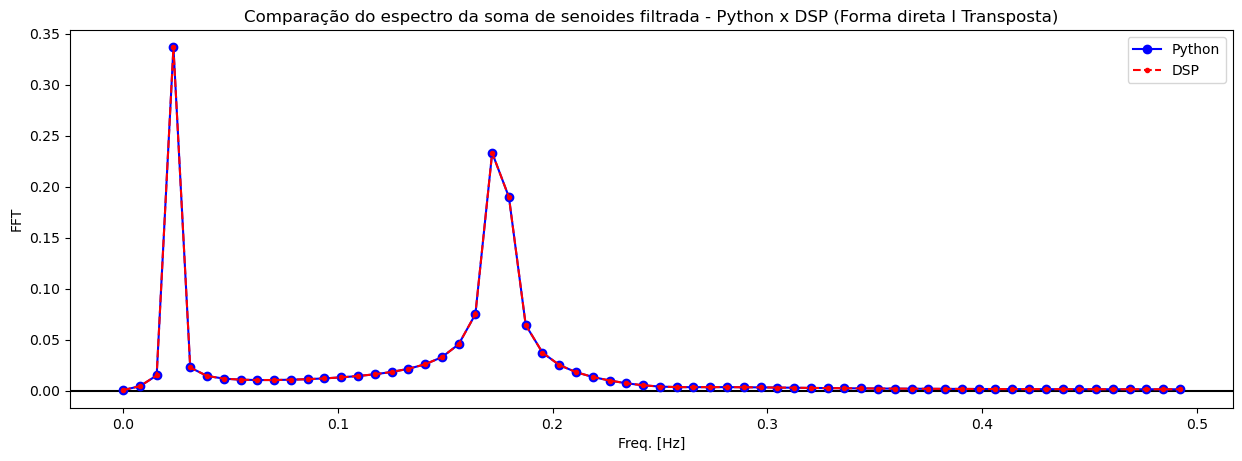

In [1756]:
y_sin = butterworthIIRTypeITransposed(input_array, num, den)

dsp_sin = np.array([420,2766,8076,13830,15029,9501,1810,901,10106,20459,19978,8824,-418,2202,12830,18764,12604,-68,-6873,-1933,7779,9962,486,-11954,-15321,-7456,1565,561,-10474,-20343,-18929,-8252,-252,-3689,-14535,-20398,-14116,-1645,4471,-1176,-10944,-12559,-2613,9674,12515,4469,-4028,-2134,9468,19294,17627,7157,10,4434,15742,21455,14979,2866,-2384,3997,13832,14989,4718,-7293,-9526,-1223,6815,4111,-7960,-17649,-15684,-5420,875,-4512,-16250,-21814,-15200,-3524,791,-6372,-16314,-17089,-6619,4989,6514,-2116,-9762,-6346,6075,15521,13199,3114,-2351,3949,16064,21452,14727,3545,214,8182,18262,18721,8161,-2928,-3647,5373,12701,8676,-3965,-13055,-10298,-353,4333,-2808,-15220,-20392,-13556,-2903,-579,-9352,-19577,-19768,-9208,1253,1089,-8382,-15459,-10930])
sin_converted = q15_to_float(dsp_sin)

plotarAmostras(y_sin, "Soma de senoides filtrada em Python - 128 amostras (Forma direta I Transposta)")
plotarAmostrasCompara(y_sin, sin_converted, "Comparação de filtragem da soma de senoides - Python x DSP (Forma direta I Transposta)")
plotarSinalFreq(y_sin, 128, 1, "Espectro da soma de senoides filtrada em Python (Forma direta I Transposta)")
plotarSinalFreqCompara(y_sin, sin_converted, 128, 1, "Comparação do espectro da soma de senoides filtrada - Python x DSP (Forma direta I Transposta)")

if(debugMode):
    print("Resultado em float (Python):", y_sin)
    print()
    print("Resultado em Q15 (Python):", float_to_q15(y_sin))
    print()
    print("Resultado em float (DSP):")
    print(sin_converted)
    print()
    print("Resultado em Q15 (DSP):")
    print(dsp_sin)

#### 4.5.3 - Sinal aleatório

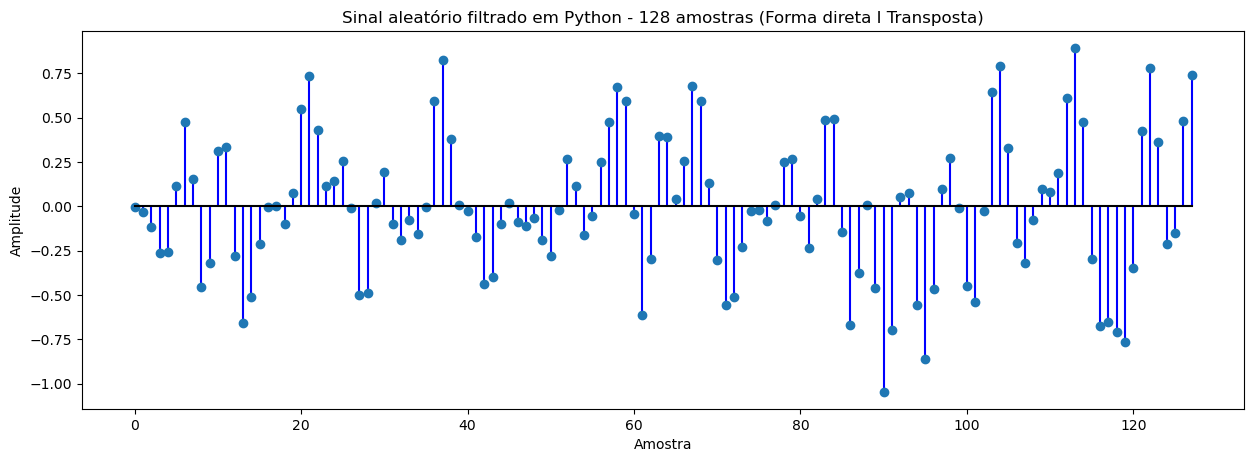

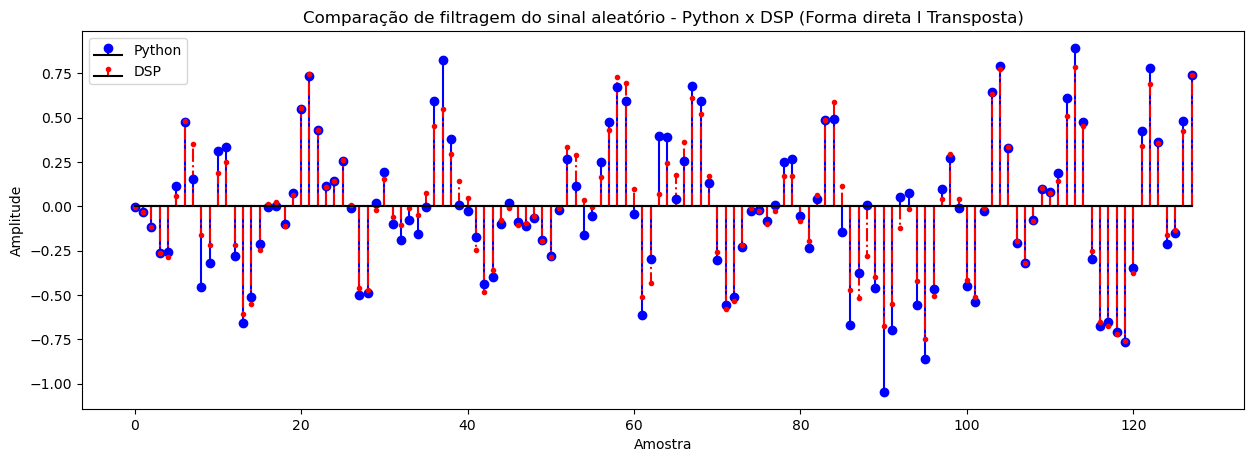

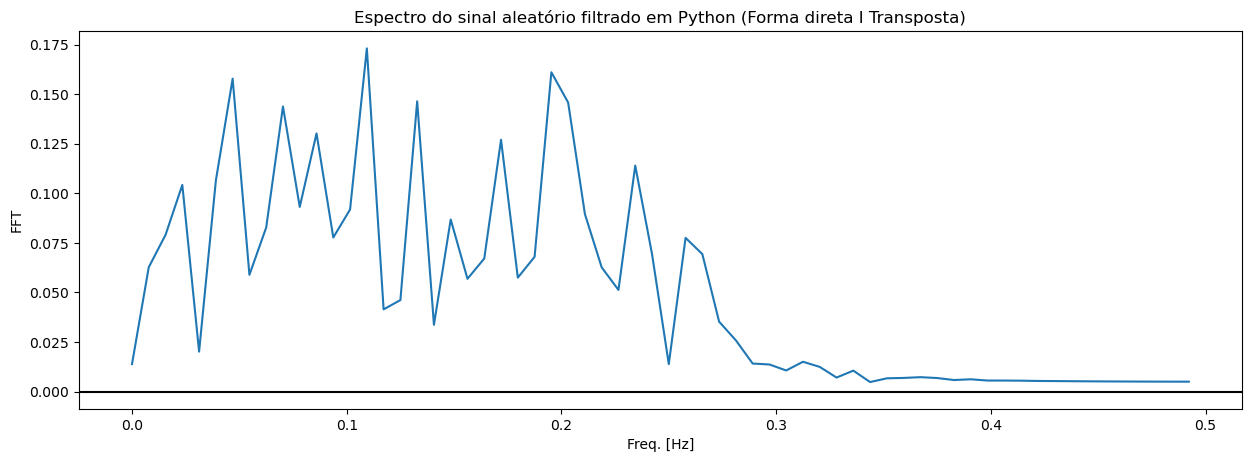

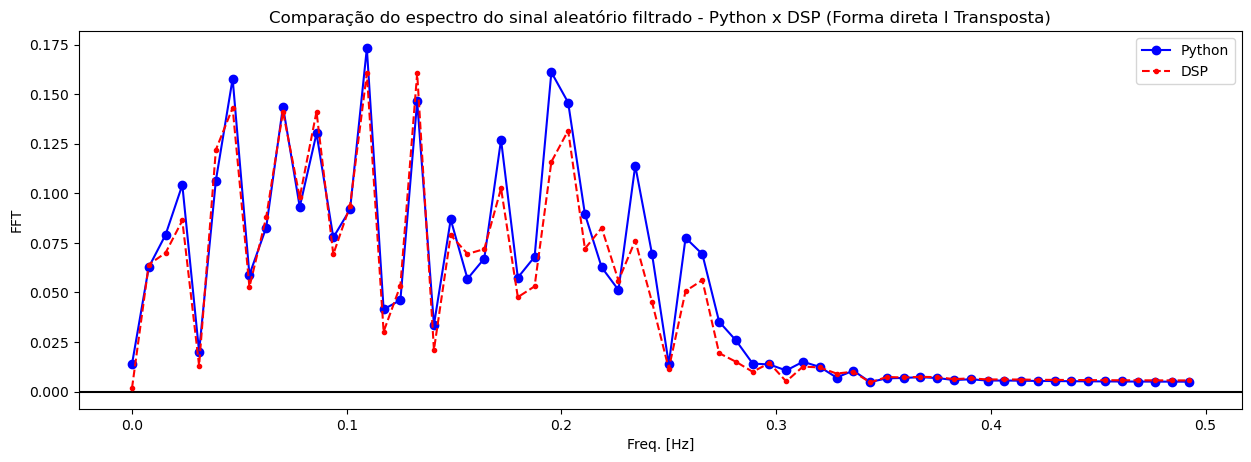

In [1757]:
y_random = butterworthIIRTypeITransposed(random_samples, num, den)

dsp_random = np.array([-126,-952,-3761,-8650,-9414,1847,15703,11483,-5229,-7099,6197,8224,-7164,-19833,-17970,-7976,502,775,-3649,2085,18205,24410,14059,3643,4732,8528,221,-15080,-15387,-583,5067,-1872,-3434,-306,-1620,2446,14833,17957,9619,4617,1555,-8042,-15866,-11684,-2415,-222,-3436,-3132,-1832,-6404,-9368,-350,11071,9532,1217,-33,5382,14055,23842,22786,3232,-16818,-14185,2233,7943,5907,11997,19974,17154,5633,-8475,-18936,-17492,-7092,-276,-885,-3210,-770,5638,5693,-2651,-6429,2183,15966,19335,3716,-15425,-16936,-9206,-12962,-22166,-17988,-3907,-522,-13730,-24578,-16600,1340,9738,1404,-13606,-16698,-233,20766,25456,10984,-6382,-10512,-2760,3338,2575,4704,16724,25719,14787,-8166,-21275,-22106,-23629,-24819,-12205,11112,22713,11695,-5202,-4336,13926,24322])
random_converted = q15_to_float(dsp_random)

plotarAmostras(y_random, "Sinal aleatório filtrado em Python - 128 amostras (Forma direta I Transposta)")
plotarAmostrasCompara(y_random, random_converted, "Comparação de filtragem do sinal aleatório - Python x DSP (Forma direta I Transposta)")
plotarSinalFreq(y_random, 128, 1, "Espectro do sinal aleatório filtrado em Python (Forma direta I Transposta)")
plotarSinalFreqCompara(y_random, random_converted, 128, 1, "Comparação do espectro do sinal aleatório filtrado - Python x DSP (Forma direta I Transposta)")

if(debugMode):
    print("Resultado em float (Python):", y_random)
    print()
    print("Resultado em Q15 (Python):", float_to_q15(y_random))
    print()
    print("Resultado em float (DSP):")
    print(random_converted)
    print()
    print("Resultado em Q15 (DSP):")
    print(dsp_random)

### 4.6 - Implementação do filtro em Forma Direta II Transposta

#### 4.6.1 - Função da Forma Direta II Transposta

In [1758]:
def butterworthIIRTypeIITransposed(x, b, a):
    def x_at(n):
        if n < 0:
            return 0
        else:
            return x[n]

    def y_at(n):
        if n < 0:
            return 0
        else:
            return y[n]

    y = np.zeros(128)

    for n in range(128):
        y[n] += b[0]*x_at(n)
        for i in range(1, N+1):
            y[n] += b[i]*x_at(n - i)
        for j in range(1, N+1):
            y[n] -= a[j]*y_at(n - j)

    return y

#### 4.6.2 - Soma de senos

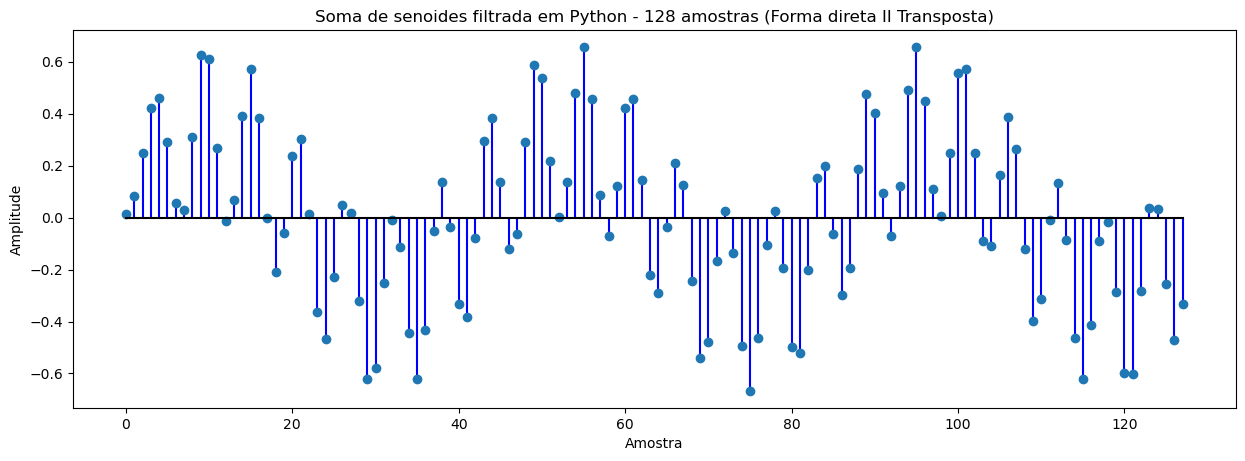

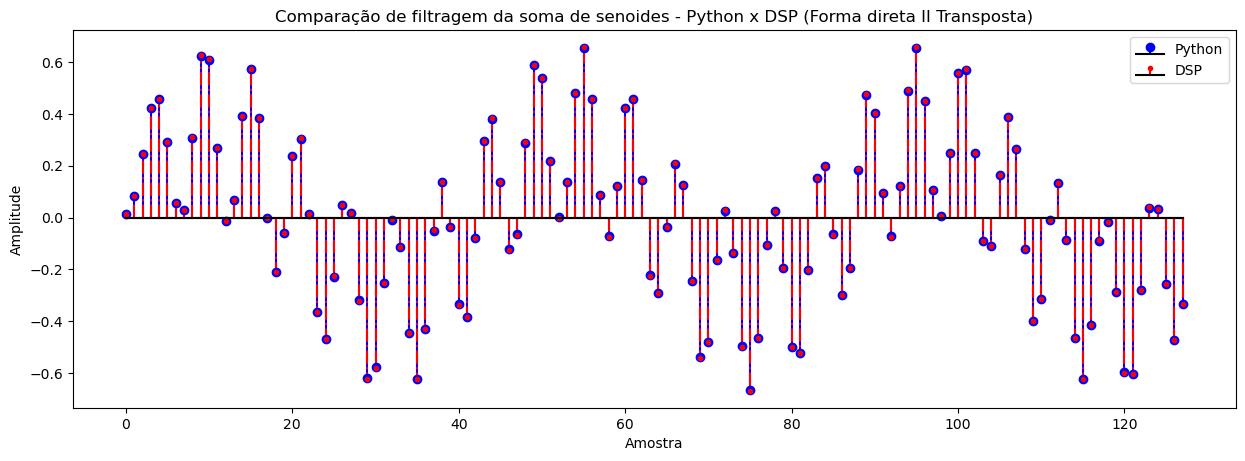

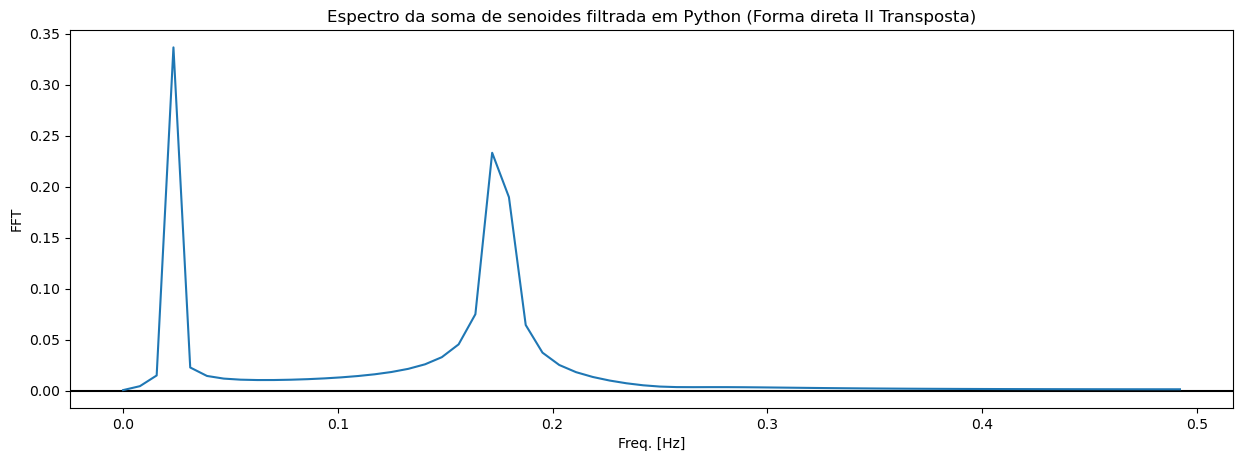

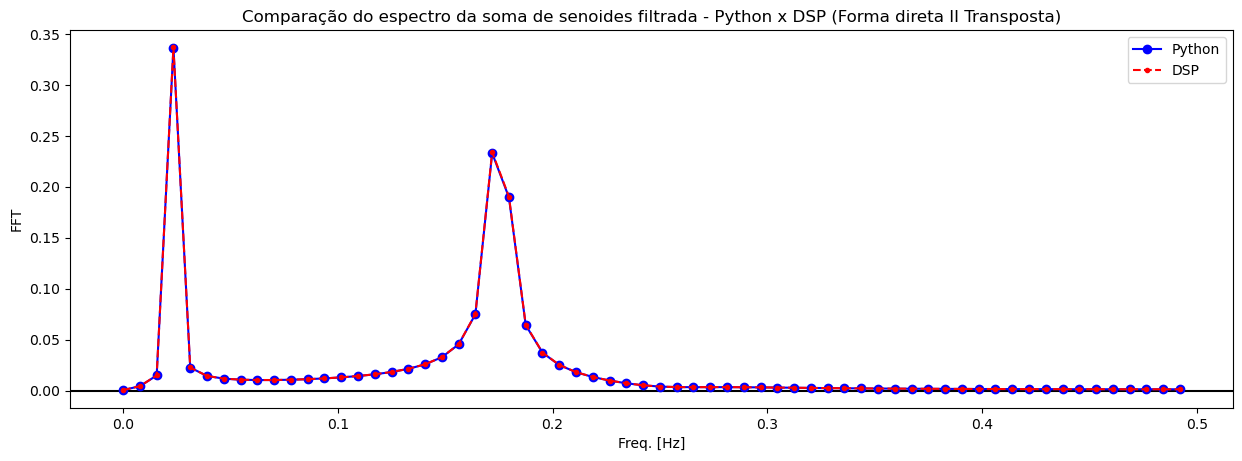

In [1759]:
y_sin = butterworthIIRTypeIITransposed(input_array, num, den)

dsp_sin = np.array([420,2766,8076,13830,15028,9500,1814,913,10131,20498,20009,8824,-442,2201,12876,18836,12638,-95,-6908,-1913,7845,10016,482,-12000,-15350,-7435,1615,582,-10507,-20406,-18963,-8233,-216,-3695,-14595,-20465,-14140,-1618,4497,-1201,-11011,-12614,-2612,9713,12539,4440,-4083,-2158,9499,19350,17655,7132,-29,4440,15804,21520,15000,2838,-2406,4026,13899,15042,4721,-7331,-9545,-1188,6876,4139,-7990,-17701,-15701,-5388,913,-4517,-16309,-21876,-15214,-3492,813,-6404,-16386,-17143,-6619,5024,6522,-2158,-9827,-6376,6099,15566,13209,3076,-2396,3951,16118,21509,14735,3512,192,8215,18335,18774,8159,-2959,-3653,5421,12770,8710,-3991,-13095,-10299,-305,4380,-2810,-15270,-20442,-13560,-2866,-554,-9386,-19647,-19818,-9204,1287,1092,-8433,-15529,-10961])
sin_converted = q15_to_float(dsp_sin)

plotarAmostras(y_sin, "Soma de senoides filtrada em Python - 128 amostras (Forma direta II Transposta)")
plotarAmostrasCompara(y_sin, sin_converted, "Comparação de filtragem da soma de senoides - Python x DSP (Forma direta II Transposta)")
plotarSinalFreq(y_sin, 128, 1, "Espectro da soma de senoides filtrada em Python (Forma direta II Transposta)")
plotarSinalFreqCompara(y_sin, sin_converted, 128, 1, "Comparação do espectro da soma de senoides filtrada - Python x DSP (Forma direta II Transposta)")

if(debugMode):
    print("Resultado em float (Python):", y_sin)
    print()
    print("Resultado em Q15 (Python):", float_to_q15(y_sin))
    print()
    print("Resultado em float (DSP):")
    print(sin_converted)
    print()
    print("Resultado em Q15 (DSP):")
    print(dsp_sin)

#### 4.6.3 - Sinal aleatório

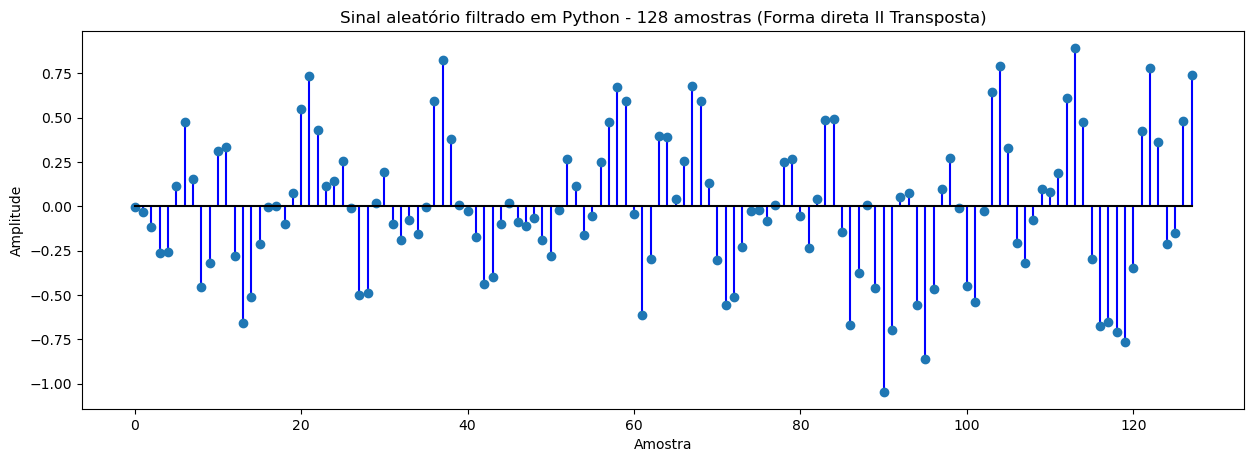

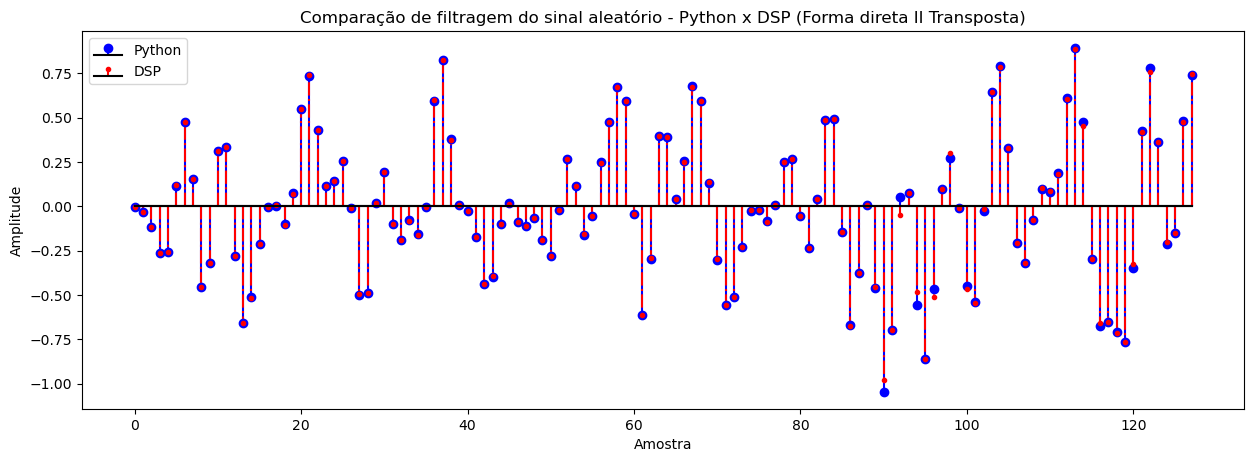

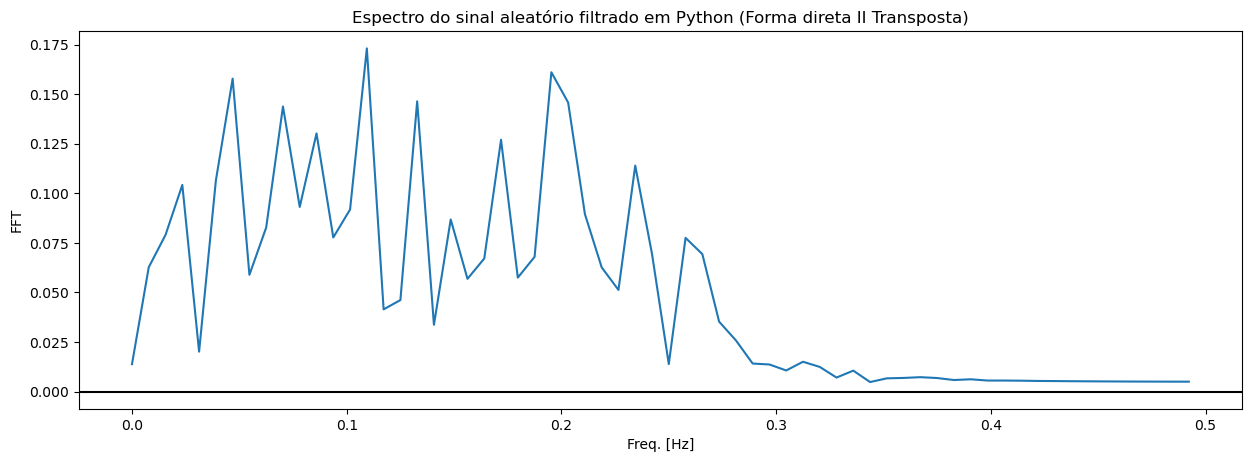

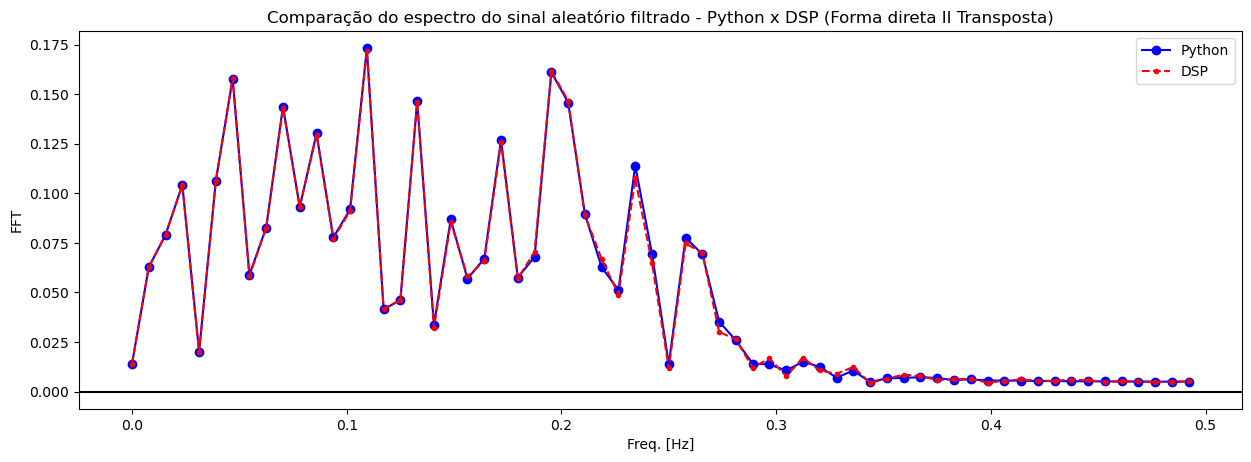

In [1760]:
y_random = butterworthIIRTypeIITransposed(random_samples, num, den)

dsp_random = np.array([-126,-952,-3761,-8505,-8447,3875,15685,5037,-14892,-10496,10239,11023,-9151,-21592,-16923,-6959,-58,218,-3363,2329,17988,24259,14195,3733,4637,8382,-261,-16208,-15981,684,6319,-3268,-6113,-2648,-5181,-44,19610,27033,12368,284,-749,-5705,-14329,-12928,-3307,485,-2917,-3566,-2188,-6175,-9066,-657,8691,3746,-5177,-1727,8107,15616,22134,19514,-1362,-20141,-9583,13035,12841,1459,8273,22133,19448,4488,-9796,-18282,-16692,-7398,-682,-704,-2828,196,8168,8686,-1824,-7732,1429,16029,16209,-4754,-21995,-12260,281,-14896,-32136,-22875,-1646,2484,-15717,-28206,-16758,3207,9884,-255,-15315,-17796,-541,21193,25821,10779,-6681,-10463,-2570,3396,2777,6063,19945,29187,14862,-9633,-21465,-21342,-23426,-24972,-10566,13772,24840,11945,-6637,-4888,15598,24444])
random_converted = q15_to_float(dsp_random)

plotarAmostras(y_random, "Sinal aleatório filtrado em Python - 128 amostras (Forma direta II Transposta)")
plotarAmostrasCompara(y_random, random_converted, "Comparação de filtragem do sinal aleatório - Python x DSP (Forma direta II Transposta)")
plotarSinalFreq(y_random, 128, 1, "Espectro do sinal aleatório filtrado em Python (Forma direta II Transposta)")
plotarSinalFreqCompara(y_random, random_converted, 128, 1, "Comparação do espectro do sinal aleatório filtrado - Python x DSP (Forma direta II Transposta)")

if(debugMode):
    print("Resultado em float (Python):", y_random)
    print()
    print("Resultado em Q15 (Python):", float_to_q15(y_random))
    print()
    print("Resultado em float (DSP):")
    print(random_converted)
    print()
    print("Resultado em Q15 (DSP):")
    print(dsp_random)

### 4.7 - Implementação do filtro em Cascata

#### 4.7.1 - Soma de senos

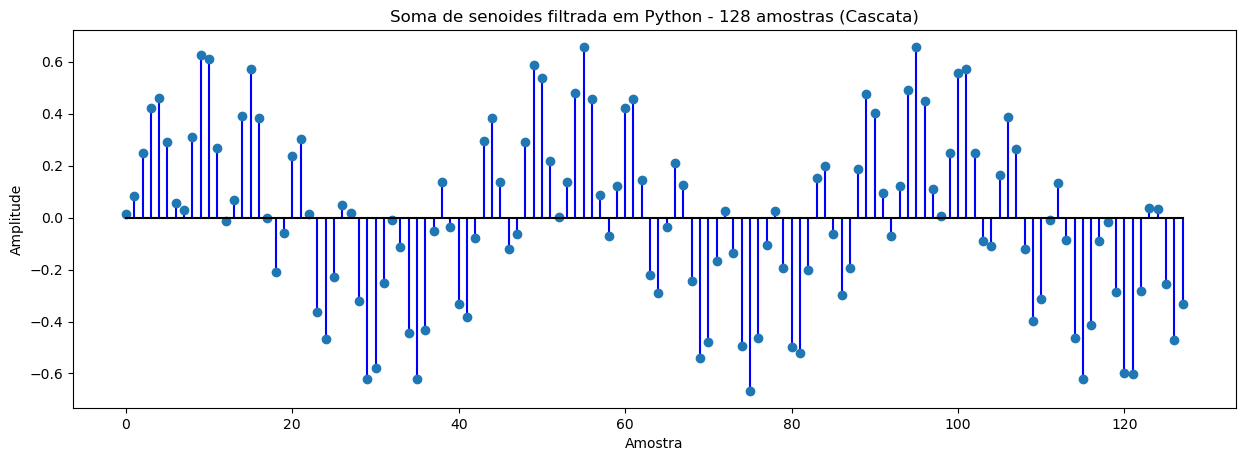

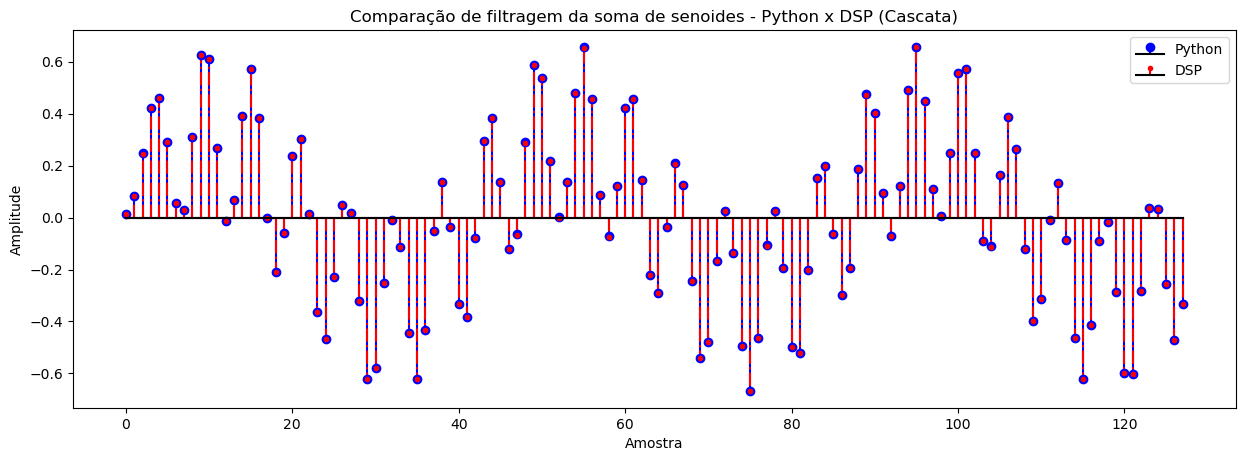

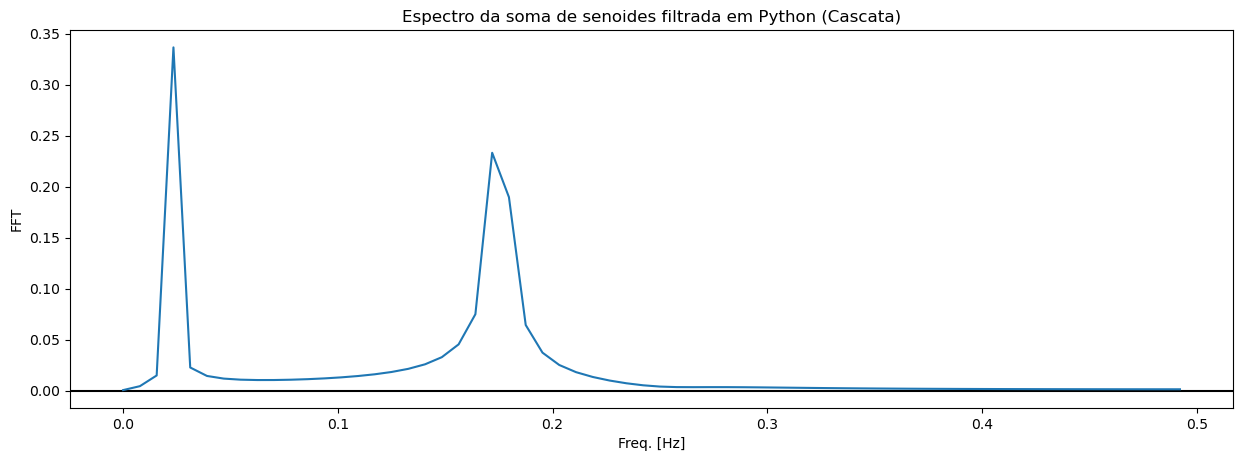

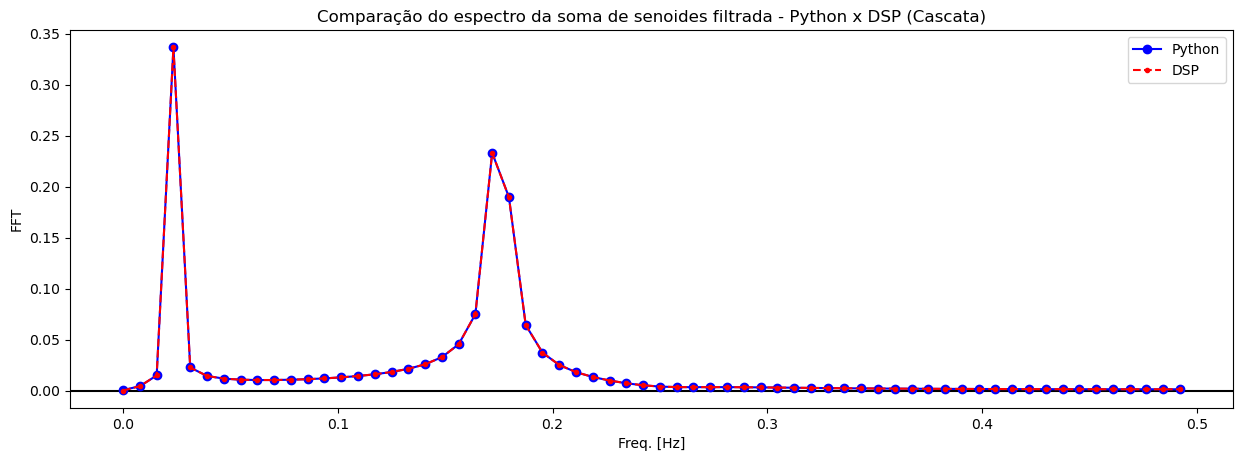

In [1761]:
y_sin = signal.sosfilt(sos, input_array)

dsp_sin = np.array([420,2756,8064,13824,15020,9488,1800,896,10104,20452,19960,8812,-424,2200,12820,18752,12592,-76,-6880,-1940,7772,9956,480,-11956,-15324,-7464,1556,552,-10480,-20348,-18932,-8256,-256,-3692,-14536,-20396,-14124,-1656,4464,-1176,-10940,-12560,-2620,9660,12504,4468,-4028,-2144,9452,19284,17620,7148,4,4428,15728,21436,14968,2860,-2392,3988,13820,14972,4708,-7292,-9524,-1228,6804,4104,-7960,-17648,-15688,-5432,864,-4512,-16252,-21816,-15204,-3528,784,-6380,-16320,-17088,-6620,4980,6504,-2116,-9764,-6352,6064,15508,13188,3108,-2356,3944,16056,21440,14712,3536,208,8172,18252,18708,8148,-2932,-3652,5368,12696,8668,-3972,-13056,-10304,-360,4328,-2812,-15224,-20396,-13564,-2908,-580,-9352,-19576,-19772,-9216,1244,1084,-8388,-15464,-10932])
sin_converted = q15_to_float(dsp_sin)

plotarAmostras(y_sin, "Soma de senoides filtrada em Python - 128 amostras (Cascata)")
plotarAmostrasCompara(y_sin, sin_converted, "Comparação de filtragem da soma de senoides - Python x DSP (Cascata)")
plotarSinalFreq(y_sin, 128, 1, "Espectro da soma de senoides filtrada em Python (Cascata)")
plotarSinalFreqCompara(y_sin, sin_converted, 128, 1, "Comparação do espectro da soma de senoides filtrada - Python x DSP (Cascata)")

if(debugMode):
    print("Resultado em float (Python):", y_sin)
    print()
    print("Resultado em Q15 (Python):", float_to_q15(y_sin))
    print()
    print("Resultado em float (DSP):")
    print(sin_converted)
    print()
    print("Resultado em Q15 (DSP):")
    print(dsp_sin)

#### 4.7.2 - Sinal aleatório

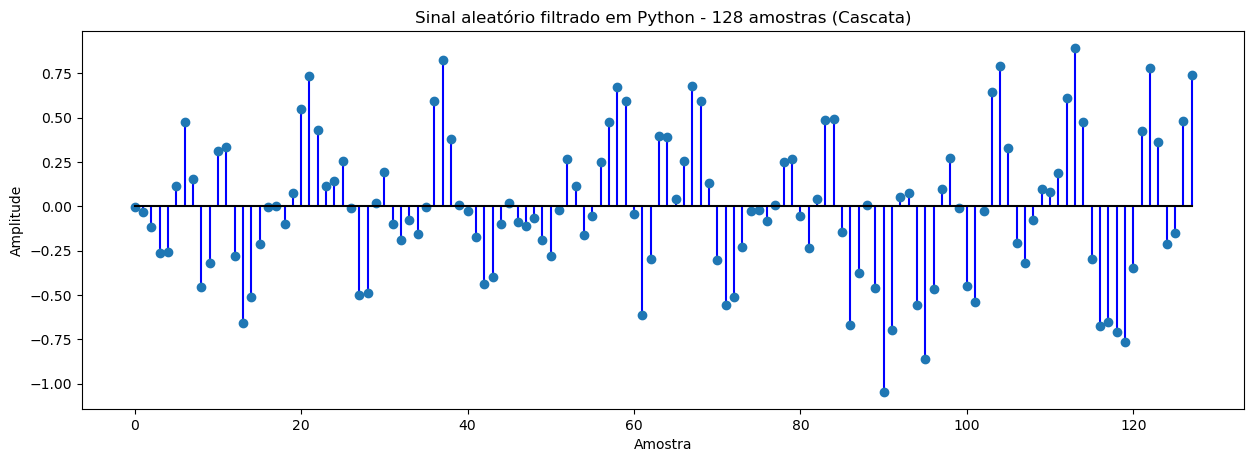

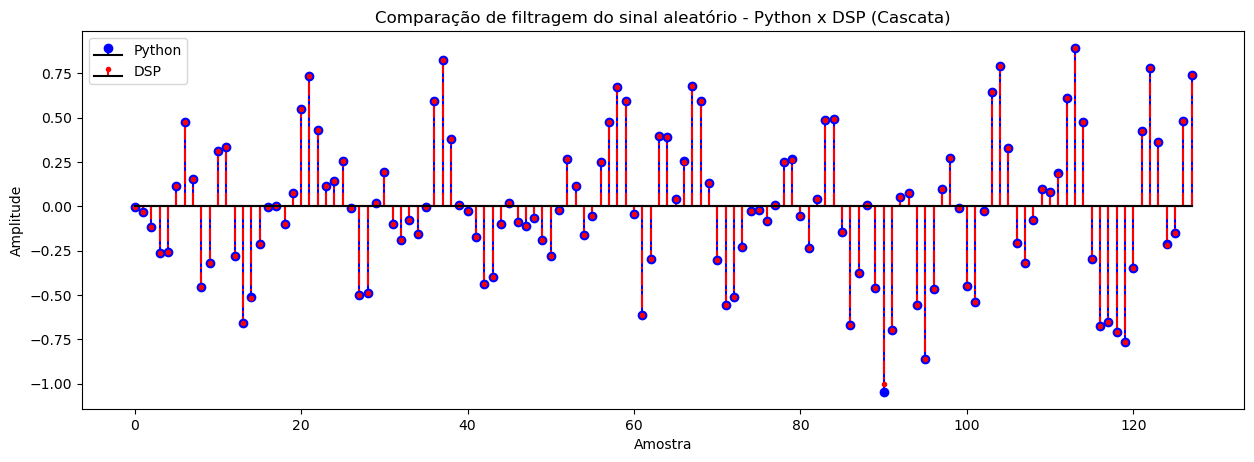

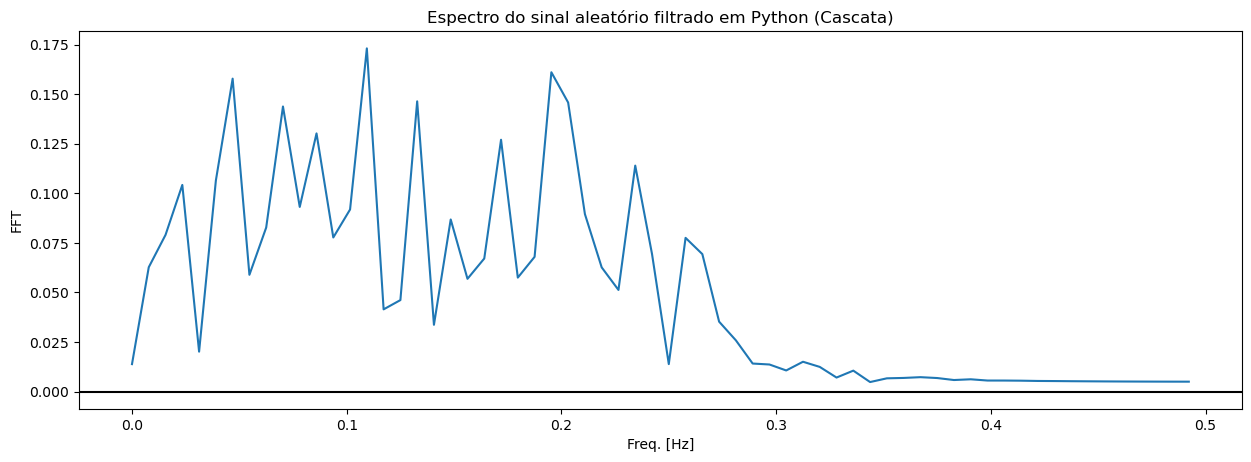

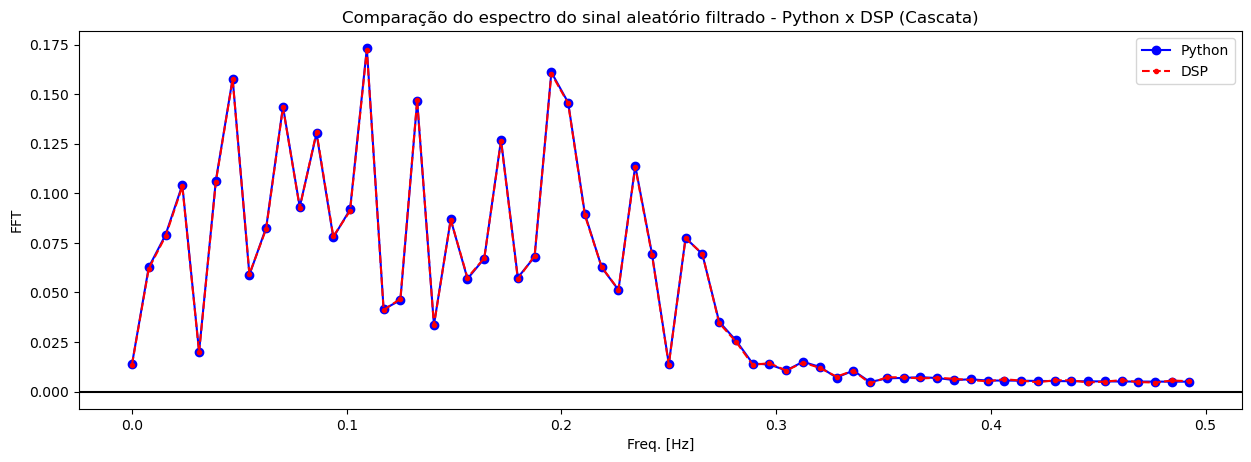

In [1762]:
y_random = signal.sosfilt(sos, random_samples)

dsp_random = np.array([-124,-952,-3768,-8512,-8452,3864,15672,5032,-14888,-10476,10248,10976,-9228,-21588,-16820,-6928,-180,140,-3264,2440,17960,24180,14184,3760,4640,8344,-340,-16280,-15976,720,6296,-3328,-6104,-2556,-5140,-124,19540,27076,12416,252,-776,-5696,-14392,-13036,-3304,564,-2912,-3600,-2148,-6120,-9088,-704,8712,3784,-5192,-1736,8136,15604,22060,19488,-1308,-20124,-9652,12964,12800,1432,8304,22216,19448,4364,-9856,-18208,-16680,-7524,-764,-644,-2744,212,8156,8676,-1840,-7740,1432,16012,16160,-4780,-21960,-12216,248,-14988,-32768,-22792,1736,2464,-18120,-28160,-15168,3248,8912,-312,-14692,-17664,-868,21068,25952,10844,-6708,-10444,-2576,3284,2680,6088,20024,29196,15612,-9672,-22076,-21340,-23112,-25072,-11460,13876,25560,11928,-7032,-4820,15844,24328])
random_converted = q15_to_float(dsp_random)

plotarAmostras(y_random, "Sinal aleatório filtrado em Python - 128 amostras (Cascata)")
plotarAmostrasCompara(y_random, random_converted, "Comparação de filtragem do sinal aleatório - Python x DSP (Cascata)")
plotarSinalFreq(y_random, 128, 1, "Espectro do sinal aleatório filtrado em Python (Cascata)")
plotarSinalFreqCompara(y_random, random_converted, 128, 1, "Comparação do espectro do sinal aleatório filtrado - Python x DSP (Cascata)")

if(debugMode):
    print("Resultado em float (Python):", y_random)
    print()
    print("Resultado em Q15 (Python):", float_to_q15(y_random))
    print()
    print("Resultado em float (DSP):")
    print(random_converted)
    print()
    print("Resultado em Q15 (DSP):")
    print(dsp_random)

### 4.8 - Implementação do filtro em Forma Paralela

#### 4.8.1 - Função da Forma Paralela

In [1763]:
def designButterworthParallel(b, a, order):
    r, p, k = signal.residuez(b, a)

    sos_parallel = []
    # Função funciona apenas para ordem par
    for i in range(int(order/2)):
        b0 = (r[2*i] + r[2*i + 1])
        b1 = - (r[2*i] * p[2*i + 1]) - (r[2*i + 1] * p[2*i])
        b2 = 0
        a0 = 1
        a1 = - (p[2*i] + p[2*i + 1])
        a2 = p[2*i] * p[2*i + 1]
        sos_parallel.append([float(b0), float(b1), float(b2), float(a0), float(a1), float(a2)])

    return sos_parallel, k

def butterworthParallel(x, b, a, order):
    sos_par, k = designButterworthParallel(b, a, order)
    filtered = []
    tmp1 = signal.sosfilt(sos_par[0], x)
    tmp2 = signal.sosfilt(sos_par[1], x)
    tmp3 = signal.sosfilt(sos_par[2], x)
    for i in range(len(x)):
        filtered.append(tmp1[i] + tmp2[i] + tmp3[i] + (k[0] * x[i]))
    return filtered

In [1764]:
if(debugMode):
    sos_par, k = designButterworthParallel(num, den, N)

    print("Coeficientes das seções paralelas:")
    print(sos_par)
    print()
    print("Coeficiente k:", k[0])
    print()

    coef_div = 32
    for i in range(0, 3):
        sos_par[0][i] /= coef_div
        sos_par[1][i] /= coef_div
        sos_par[2][i] /= coef_div
    k /= coef_div
    print("Coeficientes das seções paralelas (após divisões para normalização):")
    print(sos_par)
    print()
    print("Coeficiente k (após divisão para normalização):", k[0])
    print()
    print("Coeficientes das seções paralelas (Q15 normalizado):")
    print(float_to_q15(sos_par))
    print()
    print("Coeficiente k (Q15 normalizado):", float_to_q15(k[0]))

#### 4.8.2 - Soma de senos

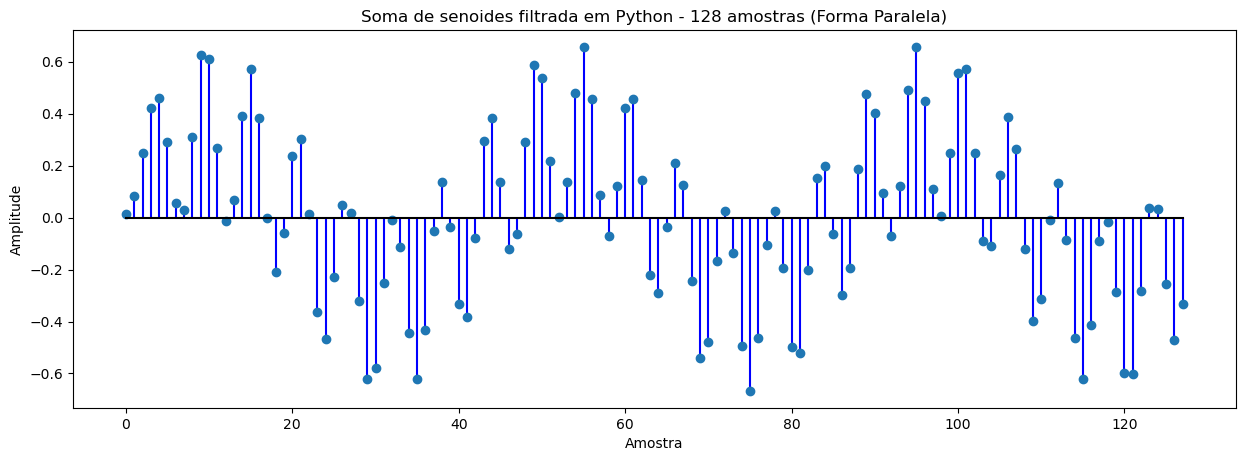

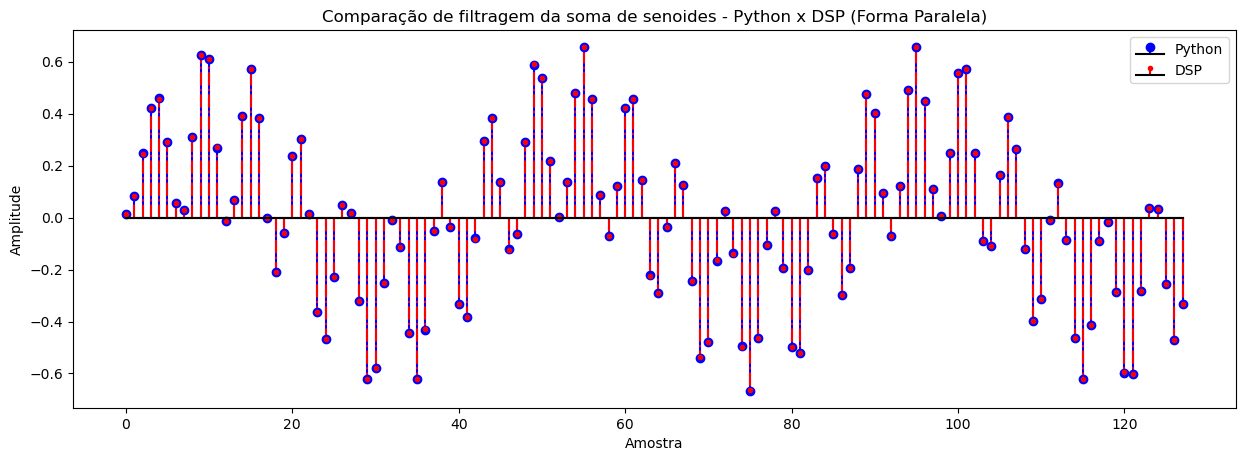

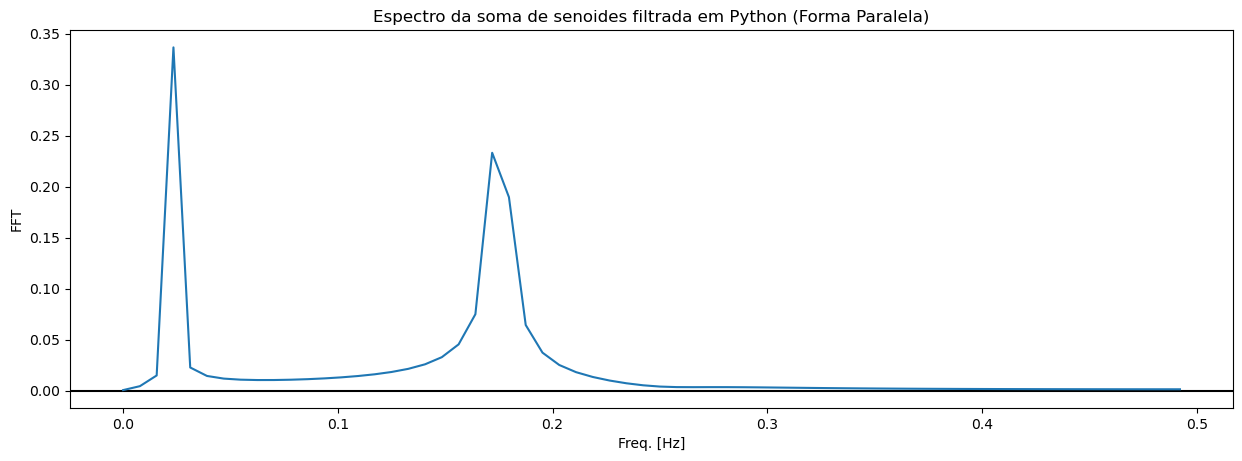

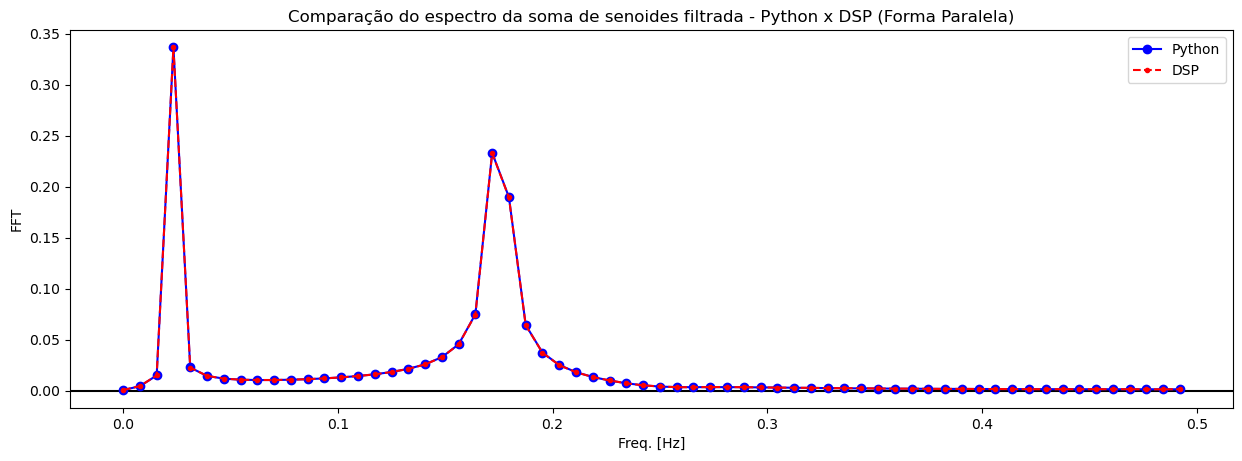

In [1765]:
y_sin = butterworthParallel(input_array, num, den, N)

dsp_sin = np.array([416,2752,8064,13856,15008,9472,1856,928,10112,20448,19936,8832,-384,2240,12832,18752,12576,-64,-6848,-1952,7744,9920,480,-11968,-15296,-7456,1536,544,-10464,-20352,-18912,-8256,-256,-3744,-14528,-20352,-14112,-1664,4448,-1216,-10912,-12512,-2656,9696,12512,4448,-4032,-2112,9472,19328,17600,7136,32,4448,15744,21440,14976,2848,-2368,4000,13824,14976,4736,-7328,-9536,-1184,6816,4096,-7968,-17632,-15712,-5408,864,-4544,-16288,-21792,-15168,-3488,768,-6400,-16288,-17056,-6592,4992,6528,-2112,-9728,-6304,6080,15520,13184,3136,-2304,3936,16032,21440,14720,3552,224,8192,18240,18688,8160,-2912,-3616,5376,12672,8672,-3968,-13056,-10272,-352,4288,-2816,-15200,-20352,-13536,-2912,-608,-9344,-19520,-19744,-9216,1216,1056,-8384,-15424,-10912])
sin_converted = q15_to_float(dsp_sin)

plotarAmostras(y_sin, "Soma de senoides filtrada em Python - 128 amostras (Forma Paralela)")
plotarAmostrasCompara(y_sin, sin_converted, "Comparação de filtragem da soma de senoides - Python x DSP (Forma Paralela)")
plotarSinalFreq(y_sin, 128, 1, "Espectro da soma de senoides filtrada em Python (Forma Paralela)")
plotarSinalFreqCompara(y_sin, sin_converted, 128, 1, "Comparação do espectro da soma de senoides filtrada - Python x DSP (Forma Paralela)")

if(debugMode):
    print("Resultado em float (Python):", y_sin)
    print()
    print("Resultado em Q15 (Python):", float_to_q15(y_sin))
    print()
    print("Resultado em float (DSP):")
    print(sin_converted)
    print()
    print("Resultado em Q15 (DSP):")
    print(dsp_sin)

#### 4.8.3 - Sinal aleatório

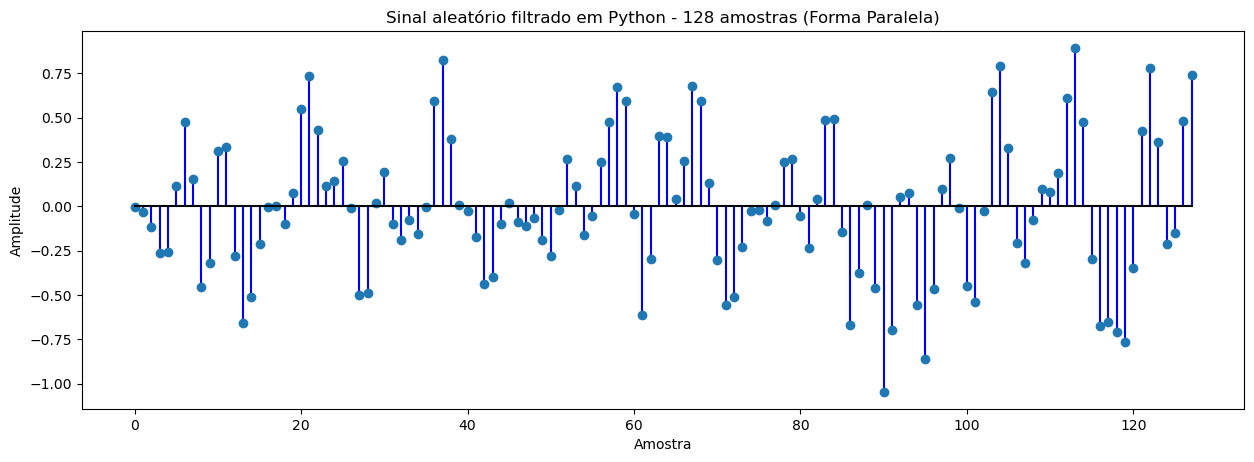

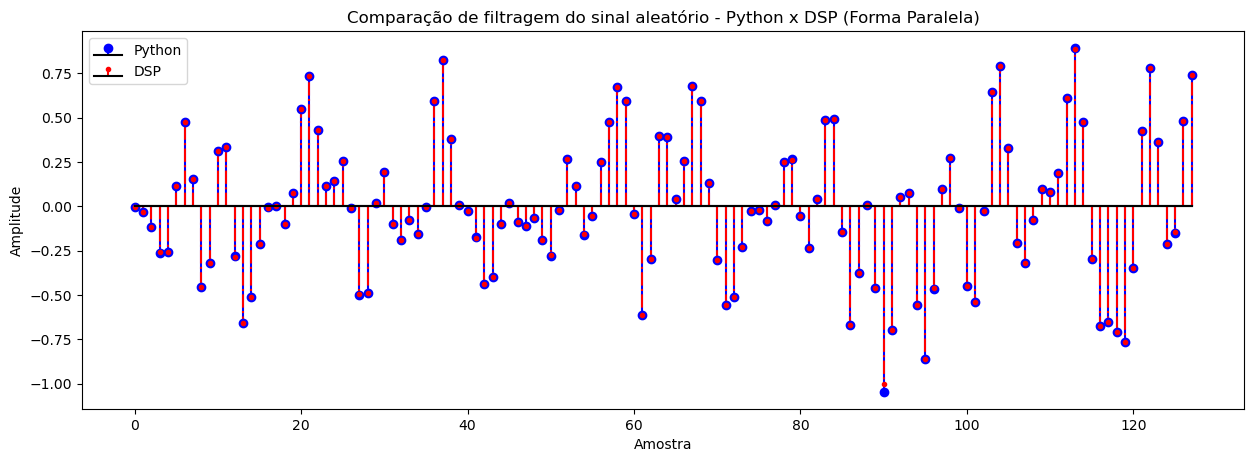

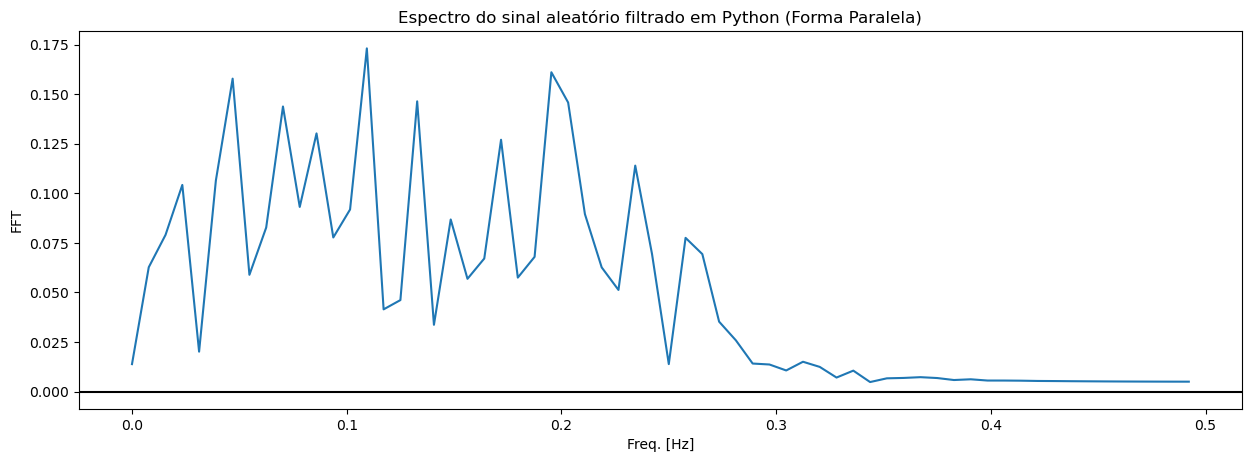

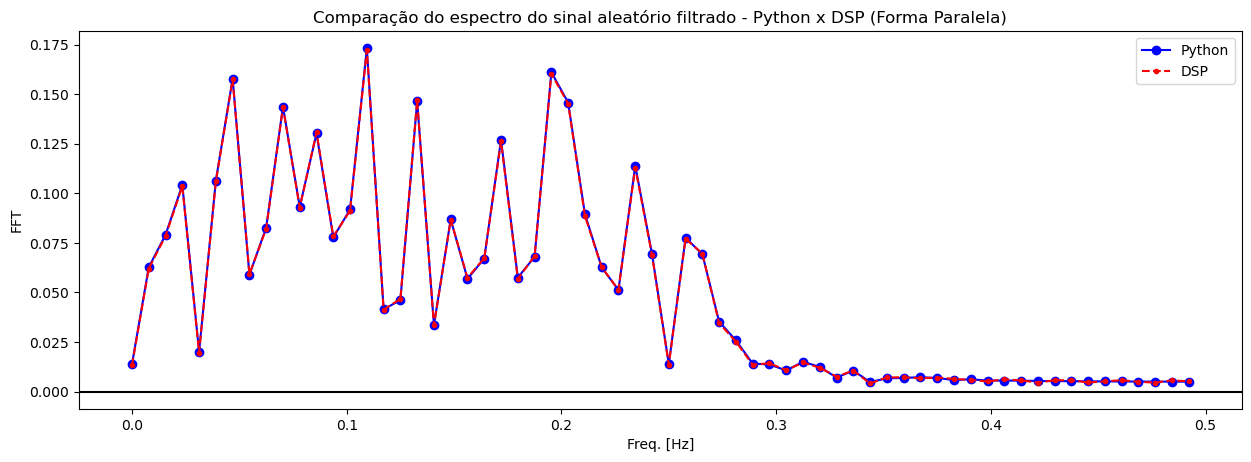

In [1766]:
y_random = butterworthParallel(random_samples, num, den, N)

dsp_random = np.array([-128,-960,-3776,-8480,-8416,3872,15648,5056,-14848,-10464,10272,10944,-9248,-21600,-16800,-6912,-192,160,-3232,2464,17984,24192,14176,3776,4640,8320,-320,-16256,-15968,704,6336,-3296,-6144,-2592,-5120,-96,19520,27072,12416,256,-800,-5760,-14400,-13024,-3264,576,-2912,-3584,-2144,-6112,-9056,-704,8736,3808,-5152,-1696,8128,15680,22048,19456,-1312,-20064,-9664,12992,12800,1440,8320,22208,19424,4352,-9856,-18208,-16672,-7488,-800,-672,-2720,224,8160,8672,-1824,-7680,1440,16000,16096,-4736,-21952,-12256,256,-14976,-32768,-22816,1728,2464,-18144,-28128,-15104,3296,8864,-320,-14656,-17664,-896,21088,25984,10848,-6720,-10432,-2528,3296,2688,6112,20032,29184,15616,-9664,-22048,-21376,-23136,-24992,-11424,13856,25536,11968,-7008,-4800,15808,24320])
random_converted = q15_to_float(dsp_random)

plotarAmostras(y_random, "Sinal aleatório filtrado em Python - 128 amostras (Forma Paralela)")
plotarAmostrasCompara(y_random, random_converted, "Comparação de filtragem do sinal aleatório - Python x DSP (Forma Paralela)")
plotarSinalFreq(y_random, 128, 1, "Espectro do sinal aleatório filtrado em Python (Forma Paralela)")
plotarSinalFreqCompara(y_random, random_converted, 128, 1, "Comparação do espectro do sinal aleatório filtrado - Python x DSP (Forma Paralela)")

if(debugMode):
    print("Resultado em float (Python):", y_random)
    print()
    print("Resultado em Q15 (Python):", float_to_q15(y_random))
    print()
    print("Resultado em float (DSP):")
    print(random_converted)
    print()
    print("Resultado em Q15 (DSP):")
    print(dsp_random)